In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ecommerce-clothing-store/products_skus.csv
/kaggle/input/ecommerce-clothing-store/products.csv
/kaggle/input/ecommerce-clothing-store/traffic.csv
/kaggle/input/ecommerce-clothing-store/orders_items.csv
/kaggle/input/ecommerce-clothing-store/orders.csv
/kaggle/input/ecommerce-clothing-store/customers.csv
/kaggle/input/ecommerce-clothing-store/transactions.csv


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Goal

#### This project is based on a e-commerce clothing startup. 
#### The goal is to explore customers and sales trends and behaviors to give the business some insights and strategies to boost sales. 

### Contents

#### Major analyses are as follows:
1. Sales Trend Analysis
2. Sales Funnel Analysis 
3. Product Analysis
4. Promotion Analysis
5. Customer Analysis
    - Churn
    - Retention
    - RFM
    - Clustering

### Key Findings

#### Website

1. Traffic strongly follows the 4 seasons. At the start of every season, traffic goes up. 
2. Traffic also follows holiday seasons, for example, Thanksgiving Day.
3. Traffic is correlated with the number of placed orders, the lower the sales funnel, the higher correlation will be.  
4. The sales funnel conversion rates in general is healthy. The one from detail view to add-to-cart is only 10%, which is the lowest.

#### Products

1. Different product types have large sales during the start of corresponding seasons, for example, dress has large sales from June to August. 
2. Some most popular combos of two product types are *maxi-pants*, *tunic-pullover*, *mini-croptop*, *jumpsuit-bodysuit*  
3. Some least popular combos of two product types are *trousers-maxi*, *trousers-midi*, *top-accessory*, *top-maxi*, *top-midi* 
4. Products bundlings within the same orders are *romper-blouse* , *sweater-jacket* , *shorts-blouse*  
5. Discounts is correlated with order price (significance test not conducted)

#### Customers

1. 25% of customers are missing full names, which is the most important shipping/billing information
2. Customers are leaving after sign-ups, some without any purchase and some with only 1 purchase
3. There is a group of loyal customers

### Recommendations

#### Website

* Improve website conversion rates:
    - Product detail page
    - Personalized and nonpersonalized recommendations
    - Page contents & variations

#### Products
* Alter inventories according to seasonality
* Promotions on holiday seasons
* Product bundling according to purchase combinations
* Larger product discounts

#### Customers
* Focus on retention by getting customer feedbacks
* Target on loyal customers

### Exploratory Data Analysis

In [3]:
# load data
# customer => website (traffic) => product/product sku => order/order items => transaction
customers = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/customers.csv').rename(columns={'id':'customer_id', 'created_at':'customer_created_at'})
traffic = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/traffic.csv').drop(columns=['index'])
products = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/products.csv').rename(columns={'id':'product_id', 'title':'product_title', 'created_at':'product_created_at', 'published_at':'product_published_at'})
prod_sku = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/products_skus.csv').rename(columns={'id':'product_sku_id', 'created_at':'sku_created_at'})
orders = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/orders.csv').rename(columns={'id':'order_id', 'created_at':'order_created_at', 'closed_at':'order_closed_at', 'cancelled_at':'order_cancelled_at', 'processed_at': 'order_processed_at'})
ord_item = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/orders_items.csv').rename(columns={'id':'order_product_id'})
transactions = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/transactions.csv').rename(columns={'id':'transaction_id', 'created_at':'transaction_created_at', 'status':'transaction_status', 'kind':'transaction_kind', 'amount':'transaction_amount'})

col_dict = {}
col_dict['customers'] = customers.columns.tolist()
col_dict['traffic'] = traffic.columns.tolist()
col_dict['products'] = products.columns.tolist()
col_dict['prod_sku'] = prod_sku.columns.tolist()
col_dict['orders'] = orders.columns.tolist()
col_dict['ord_item'] = ord_item.columns.tolist()
col_dict['transactions'] = transactions.columns.tolist()

print('customers:', col_dict['customers'])
print('traffic:', col_dict['traffic'])
print('products:', col_dict['products'])
print('prod_sku:', col_dict['prod_sku'])
print('orders:', col_dict['orders'])
print('ord_item:', col_dict['ord_item'])
print('transactions:', col_dict['transactions'])

customers: ['customer_id', 'full_name', 'customer_created_at']
traffic: ['date_day', 'page_views', 'sessions', 'product_detail_views', 'product_checkouts', 'product_adds_to_carts', 'avg_session_in_s']
products: ['product_id', 'product_title', 'product_type', 'product_created_at', 'product_published_at']
prod_sku: ['product_sku_id', 'product_id', 'product_style', 'sku', 'sku_created_at', 'price']
orders: ['order_id', 'order_created_at', 'order_closed_at', 'order_cancelled_at', 'customer_id', 'financial_status', 'fulfillment_status', 'order_processed_at', 'total_price', 'shipping_rate', 'subtotal_price', 'total_discounts', 'total_line_items_price']
ord_item: ['order_product_id', 'order_id', 'product_id', 'product_style', 'variant_id', 'sku', 'product_title', 'fulfillment_status', 'price', 'quantity']
transactions: ['order_id', 'transaction_id', 'parent_id', 'transaction_amount', 'error_code', 'transaction_kind', 'transaction_status', 'transaction_created_at']


#### No. Customers:

In [4]:
print("There are {} customers, {} don't have full names, which is {:.2%}.".format(customers['customer_id'].nunique(), customers['full_name'].isnull().sum(), customers['full_name'].isnull().sum() / customers['customer_id'].nunique()))
print("{} are unique full names and {} are duplicates.".format(customers['full_name'].nunique(), customers['customer_id'].nunique() - customers['full_name'].nunique()))

There are 44661 customers, 10962 don't have full names, which is 24.54%.
28638 are unique full names and 16023 are duplicates.


#### Customers with Different # Orders 

In [23]:

customer_order_ratios = (pd.merge(customers,
                                  orders, 
                                  on='customer_id', 
                                  how='left')
                         .groupby(['customer_id'])['order_id'].nunique()
                         .reset_index()
                         .rename(columns={'order_id':'num_orders'}))['num_orders'].value_counts().reset_index().rename(columns={'num_orders':'num_customers','index':'num_orders'})


customer_order_ratios['ratio_customers'] = np.round(customer_order_ratios['num_customers'] / customer_order_ratios['num_customers'].sum(), 4)
print('Ratio of customers having 0 order = {} ({:.2%})'.format(customer_order_ratios.loc[lambda x: x['num_orders'] == 0]['num_customers'].values[0], customer_order_ratios.loc[lambda x: x['num_orders'] == 0]['ratio_customers'].values[0]))
print('Ratio of customers having 1 order = {} ({:.2%})'.format(customer_order_ratios.loc[lambda x: x['num_orders'] == 1]['num_customers'].values[0], customer_order_ratios.loc[lambda x: x['num_orders'] == 1]['ratio_customers'].values[0]))
customer_order_ratios

Ratio of customers having 0 order = 29726 (66.56%)
Ratio of customers having 1 order = 11683 (26.16%)


,num_orders,num_customers,ratio_customers
0,0,29726,0.6656
1,1,11683,0.2616
2,2,2032,0.0455
3,3,626,0.0140
4,4,274,0.0061
5,5,122,0.0027
6,6,61,0.0014
7,7,44,0.0010
8,8,34,0.0008
9,9,17,0.0004


#### Traffic (Pageviews):

Avg. daily # pageviews = 18542
Medium. daily # pageviews = 10417
# outliers = 9 [625003, 220707, 226285, 137956, 169100, 187239, 192006, 136682, 160544]


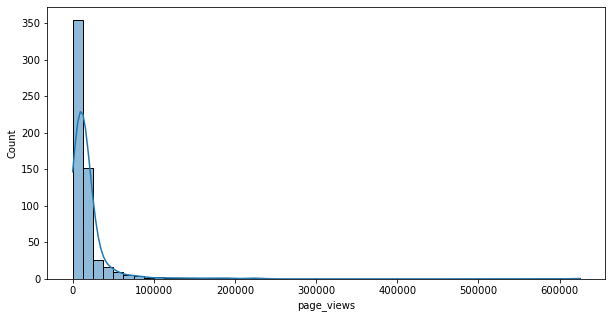

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(data=traffic, x='page_views', bins=50, kde=True)
print('Avg. daily # pageviews = {:.0f}'.format(traffic['page_views'].mean()))
print('Medium. daily # pageviews = {:.0f}'.format(traffic['page_views'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['page_views'])) > 3, 'page_views'].count(), traffic.loc[np.abs(stats.zscore(traffic['page_views'])) > 3, 'page_views'].tolist()))

#### No. Product Detail Pageviews:

Avg. daily # product detail pageviews = 4957
Median daily # product detail pageviews = 2670
# outliers = 8 [175257, 58940, 65644, 34996, 60816, 60005, 57313, 40927]


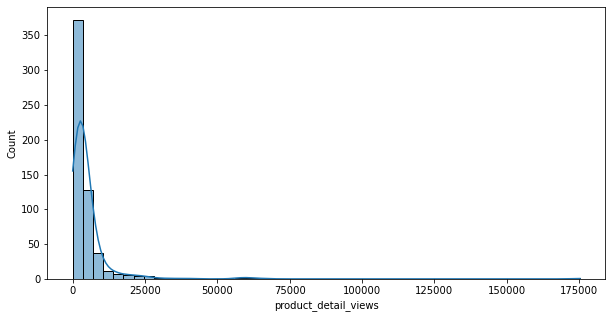

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(data=traffic, x='product_detail_views', bins=50, kde=True)
print('Avg. daily # product detail pageviews = {:.0f}'.format(traffic['product_detail_views'].mean()))
print('Median daily # product detail pageviews = {:.0f}'.format(traffic['product_detail_views'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['product_detail_views'])) > 3, 'product_detail_views'].count(), traffic.loc[np.abs(stats.zscore(traffic['product_detail_views'])) > 3, 'product_detail_views'].tolist()))

#### No. Add2Carts:

Avg. daily # add-to-carts = 499
Median daily # add-to-carts = 262
# outliers = 9 [10851, 4763, 4301, 5700, 9450, 3408, 8299, 3273, 4434]


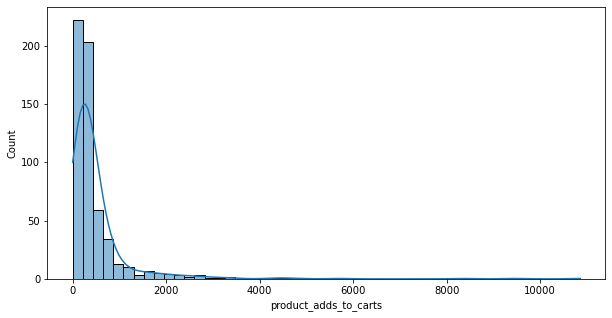

In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(data=traffic, x='product_adds_to_carts', bins=50, kde=True)
print('Avg. daily # add-to-carts = {:.0f}'.format(traffic['product_adds_to_carts'].mean()))
print('Median daily # add-to-carts = {:.0f}'.format(traffic['product_adds_to_carts'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['product_adds_to_carts'])) > 3, 'product_adds_to_carts'].count(), traffic.loc[np.abs(stats.zscore(traffic['product_adds_to_carts'])) > 3, 'product_adds_to_carts'].tolist()))

#### No. Checkouts:

Avg. daily # checkouts = 146
Median daily # checkouts = 62
# outliers = 9 [5639, 2001, 1644, 1228, 1840, 1312, 1852, 1794, 1378]


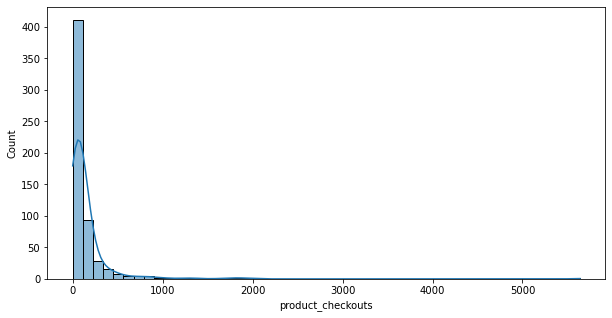

In [9]:
plt.figure(figsize=(10,5))
sns.histplot(data=traffic, x='product_checkouts', bins=50, kde=True)
print('Avg. daily # checkouts = {:.0f}'.format(traffic['product_checkouts'].mean()))
print('Median daily # checkouts = {:.0f}'.format(traffic['product_checkouts'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['product_checkouts'])) > 3, 'product_checkouts'].count(), traffic.loc[np.abs(stats.zscore(traffic['product_checkouts'])) > 3, 'product_checkouts'].tolist()))

#### Sessions:

Avg. daily # sessions = 4461
Median daily # sessions = 2693
# outliers = 9 [146860, 61654, 46927, 31815, 31239, 32166, 36614, 45385, 35921]


Avg. of daily average session in seconds = 145.33
Median. of daily average session in seconds = 132.61
# outliers = 4 [2374.17 1632.11 1891.25 1557.96]


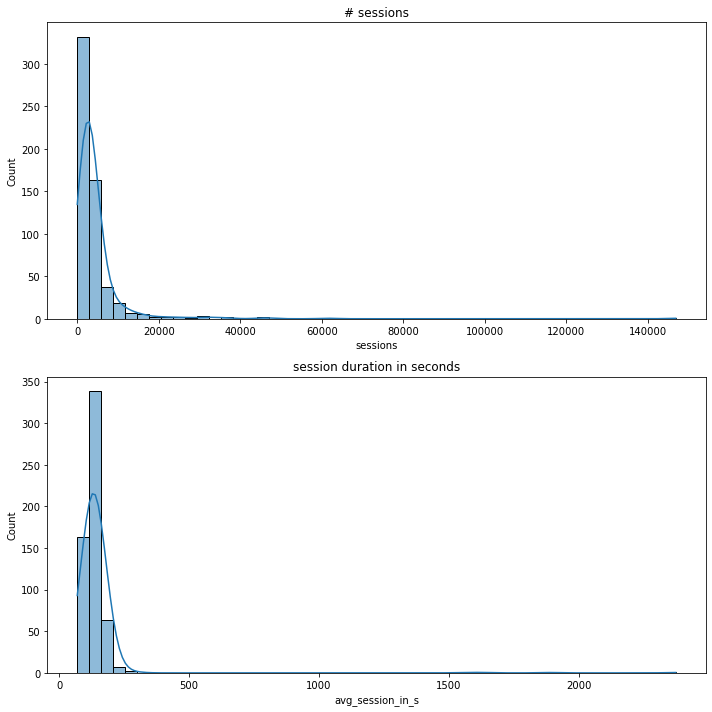

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
sns.histplot(data=traffic, x='sessions', ax=ax1, bins=50, kde=True)
ax1.set_title('# sessions')
sns.histplot(data=traffic, x='avg_session_in_s', ax=ax2, bins=50, kde=True)
ax2.set_title('session duration in seconds')
print('Avg. daily # sessions = {:.0f}'.format(traffic['sessions'].mean()))
print('Median daily # sessions = {:.0f}'.format(traffic['sessions'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['sessions'])) > 3, 'sessions'].count(), traffic.loc[np.abs(stats.zscore(traffic['sessions'])) > 3, 'sessions'].tolist()))
print('\n')
print('Avg. of daily average session in seconds = {:.2f}'.format(traffic['avg_session_in_s'].mean()))
print('Median. of daily average session in seconds = {:.2f}'.format(traffic['avg_session_in_s'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['avg_session_in_s'])) > 3, 'avg_session_in_s'].count(), np.round(traffic.loc[np.abs(stats.zscore(traffic['avg_session_in_s'])) > 3, 'avg_session_in_s'].tolist(), 2)))
fig.tight_layout()

#### Product Types:

There are 247 products and 28 product types.
* Hooide==hoodie, Tousers==Trousers, and mixed-cases to be improved...


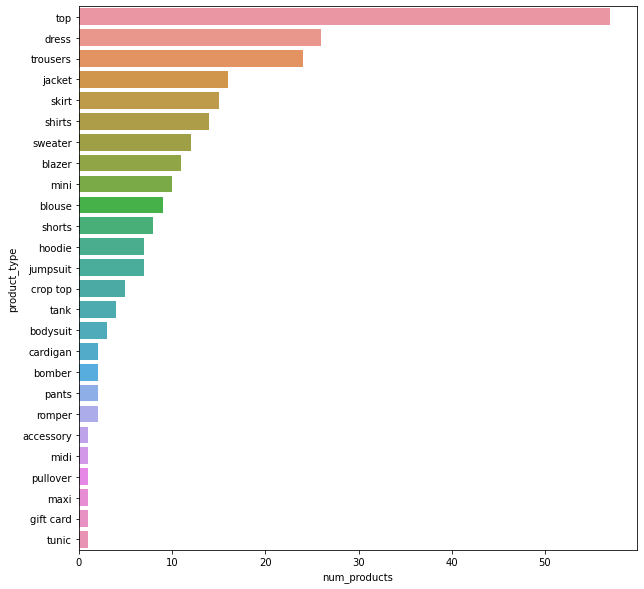

In [11]:
print('There are {} products and {} product types.'.format(products['product_id'].nunique(), products['product_type'].nunique()))
print('* Hooide==hoodie, Tousers==Trousers, and mixed-cases to be improved...')

products['product_type'] = products['product_type'].str.lower()
products.loc[lambda x: x['product_type'] == 'tousers', 'product_type'] = 'trousers'
products.loc[lambda x: x['product_type'] == 'hooide', 'product_type'] = 'hoodie'
plt.figure(figsize=(10, 10))
sns.barplot(data=products.groupby(['product_type'])['product_id'].count().reset_index().rename(columns={'product_id':'num_products'}).sort_values(by=['num_products'], ascending=False), 
            x='num_products',
            y='product_type');

#### Product SKU (Stock Keeping Unit):

In [12]:
print('There are {} SKUs, which means some products have multiple SKUs.'.format(prod_sku['sku'].nunique()))

There are 1353 SKUs, which means some products have multiple SKUs.


- Min price = 0.00
- Upper quartile price = 55.00
- Median price = 40.00
- Lower quartile price = 29.00
- Max price = 300.00
There are 5 outliers: [['gift card', 300.0], [nan, 150.0], [nan, 150.0], [nan, 150.0], [nan, 150.0]]


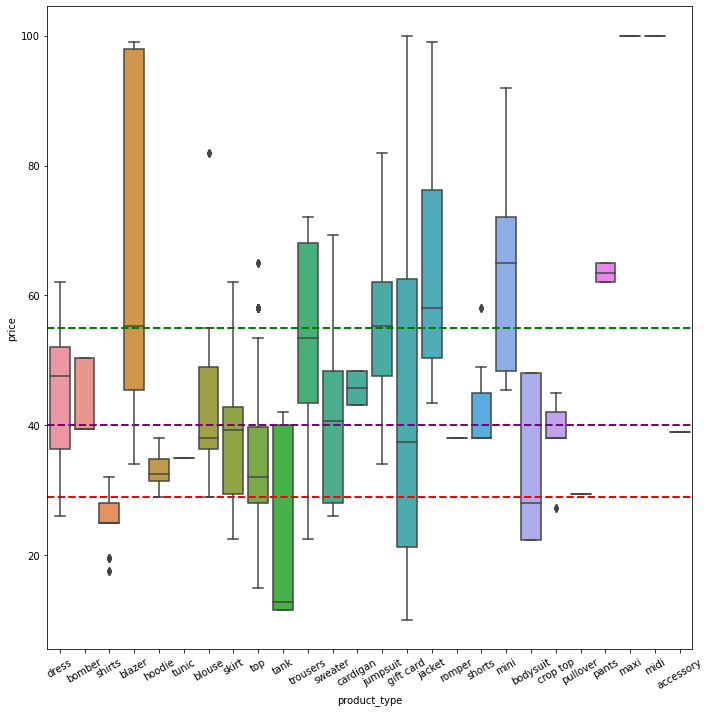

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 10))
sns.boxplot(data=pd.merge(products, prod_sku.loc[lambda x: x['price'] != x['price'].max()], on='product_id'), y='price', x='product_type', ax=ax1)
ax1.set_xticklabels(labels=ax1.get_xticklabels(), rotation=30)
ax1.hlines(y=prod_sku['price'].median(), xmin=min(ax1.get_xlim()), xmax=max(ax1.get_xlim()), linestyle='dashed', linewidth=2, color='purple')
ax1.hlines(y=prod_sku['price'].quantile(0.25), xmin=min(ax1.get_xlim()), xmax=max(ax1.get_xlim()), linestyle='dashed', linewidth=2, color='red')
ax1.hlines(y=prod_sku['price'].quantile(0.75), xmin=min(ax1.get_xlim()), xmax=max(ax1.get_xlim()), linestyle='dashed', linewidth=2, color='green')
fig.tight_layout()

print('- Min price = {:.2f}'.format(prod_sku['price'].min()))
print('- Upper quartile price = {:.2f}'.format(prod_sku['price'].quantile(0.75)))
print('- Median price = {:.2f}'.format(prod_sku['price'].median()))
print('- Lower quartile price = {:.2f}'.format(prod_sku['price'].quantile(0.25)))
print('- Max price = {:.2f}'.format(prod_sku['price'].max()))
print('There are {} outliers: {}'.format(prod_sku.loc[np.abs(stats.zscore(prod_sku['price'])) > 3].shape[0], pd.merge(products, prod_sku, on='product_id').loc[lambda x: np.abs(stats.zscore(x['price'])) > 3, ['product_type', 'price']].values.tolist()))

#### Orders:

In [14]:
print('There are {} orders.'.format(orders['order_id'].nunique()))

There are 21358 orders.


In [15]:
print(orders[['order_created_at', 'order_processed_at', 'order_closed_at', 'order_cancelled_at']].notnull().drop_duplicates().reset_index(drop=True), '\n')
print("Order creation & process date doesn't have NaNs, and theoretically order close date should be later than order cancel date.")
print('* There are {} record having close date before cancel date.'.format(orders.loc[lambda x: x['order_closed_at'] < x['order_cancelled_at']].shape[0]))

   order_created_at  order_processed_at  order_closed_at  order_cancelled_at
0              True                True             True                True
1              True                True             True               False
2              True                True            False                True
3              True                True            False               False 

Order creation & process date doesn't have NaNs, and theoretically order close date should be later than order cancel date.
* There are 1 record having close date before cancel date.


In [16]:
print("When orders haven't been closed yet, most of them are not fulfilled or only partially fulfilled: \n{}".format(orders.loc[lambda x: x['order_closed_at'].isnull()]['fulfillment_status'].value_counts(dropna=False).to_dict()))
print("If they are fulfilled but still not closed yet, the financial status are: \n{}".format(orders.loc[lambda x: x['order_closed_at'].isnull() & (x['fulfillment_status'] == 'fulfilled')]['financial_status'].value_counts(dropna=False).to_dict()))

When orders haven't been closed yet, most of them are not fulfilled or only partially fulfilled: 
{nan: 658, 'partial': 308, 'fulfilled': 195, 'restocked': 2}
If they are fulfilled but still not closed yet, the financial status are: 
{'partially_refunded': 180, 'refunded': 15}


#### Fulfillment Status:

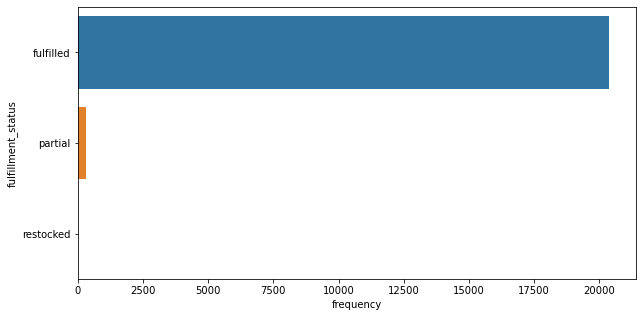

In [17]:
plt.figure(figsize=(10, 5))
sns.barplot(data=orders['fulfillment_status'].value_counts(dropna=True).reset_index().rename(columns={'index':'fulfillment_status', 'fulfillment_status':'frequency'}), x='frequency', y='fulfillment_status');

#### Financial Status:

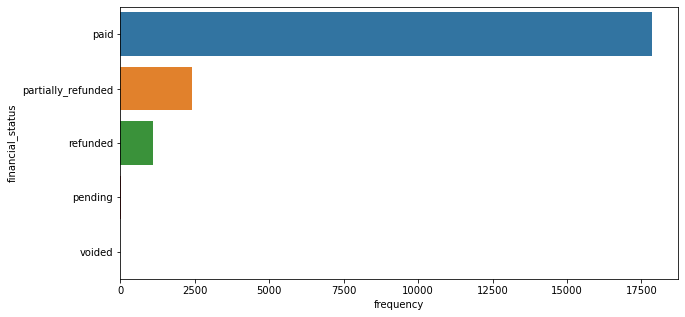

In [18]:
plt.figure(figsize=(10, 5))
sns.barplot(data=orders['financial_status'].value_counts(dropna=True).reset_index().rename(columns={'index':'financial_status', 'financial_status':'frequency'}), x='frequency', y='financial_status');

#### Order Size (# items/order):

Some stats for # items/order: 
count    21355.000000
mean         1.735659
std          1.712648
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        127.000000
Name: quantity, dtype: float64


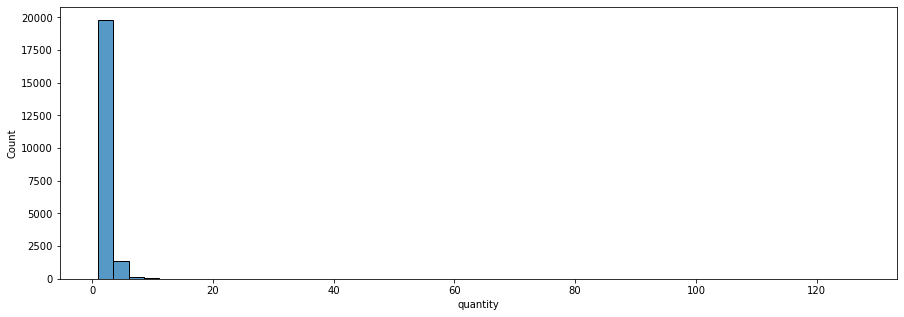

In [19]:
plt.figure(figsize=(15, 5))
print('Some stats for # items/order: \n{}'.format(pd.merge(products, ord_item, on='product_id').groupby(['order_id'])['quantity'].sum().reset_index()['quantity'].describe()))
sns.histplot(data=pd.merge(products, ord_item, on='product_id').groupby(['order_id'])['quantity'].sum().reset_index(), x='quantity', bins=50);

In [20]:
print('For those orders having at least 2 items:')
order_over_2 = (pd.merge(products, ord_item, on='product_id').groupby(['order_id'])['quantity'].sum().reset_index().loc[lambda x: x['quantity'] >= 2]['order_id'])
product_bundle = pd.merge(products, ord_item, on='product_id')
product_bundle = pd.pivot_table(product_bundle.loc[lambda x: x['order_id'].isin(order_over_2)],
               index='order_id',
               columns=['product_type'],
               values=['quantity'],
               aggfunc='sum',
               fill_value=0).reset_index()
product_bundle.columns[1]
product_bundle.columns = [product_bundle.columns[0][0]] + [product_bundle.columns[i][1] for i in range(1, len(product_bundle.columns))]
product_bundle = product_bundle.set_index('order_id')

product_bundle['item_freq'] = product_bundle.apply(lambda x: {col:x[col] for col in product_bundle.columns if x[col] > 0}, axis=1)
product_bundle.head()


For those orders having at least 2 items:


,accessory,blazer,blouse,bodysuit,bomber,cardigan,crop top,dress,gift card,hoodie,...,romper,shirts,shorts,skirt,sweater,tank,top,trousers,tunic,item_freq
order_id,,,,,,,,,,,,,,,,,,,,,
7676331935,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"{'bomber': 1, 'tunic': 1}"
7676363167,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,"{'shirts': 1, 'trousers': 1}"
7676539359,0,0,0,0,0,0,0,0,0,1,...,0,3,0,0,0,0,0,0,0,"{'hoodie': 1, 'shirts': 3}"
7676549855,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"{'blouse': 1, 'shirts': 1}"
7676564127,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,"{'hoodie': 1, 'tunic': 1}"


#### Order Price:

The order price follows this order: total_line_items_price ==> total_discounts ==> subtotal_price ==> shipping_rate ==> total_price
* (+) means add-on price, (-) means deduct price.


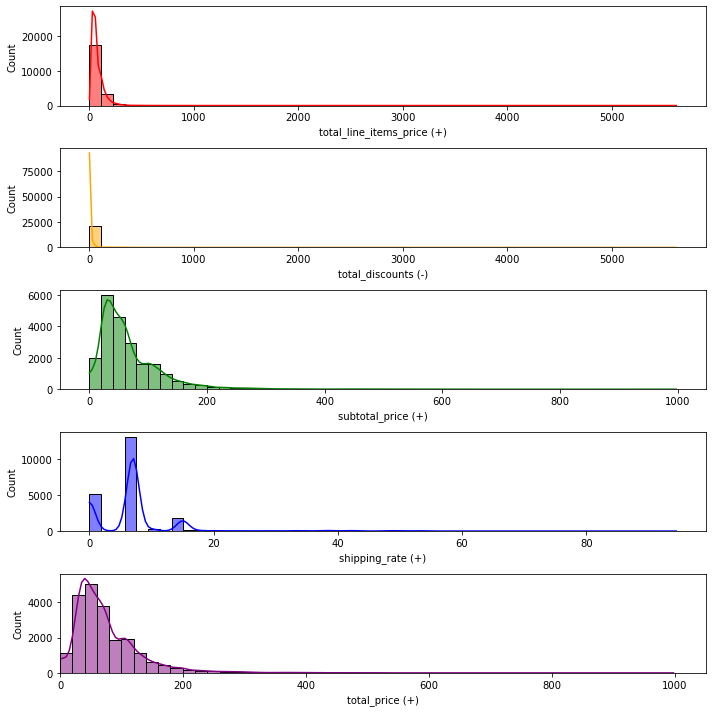

In [21]:
temp = orders[['total_line_items_price', 'total_discounts', 'subtotal_price', 'shipping_rate', 'total_price']]
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, figsize=(10, 10))

sns.histplot(data=temp, x='total_line_items_price', ax=ax1, bins=50, kde=True, color='red')
sns.histplot(data=temp, x='total_discounts', ax=ax2, bins=50, kde=True, color='orange')
sns.histplot(data=temp, x='subtotal_price', ax=ax3, bins=50, kde=True, color='green')
sns.histplot(data=temp, x='shipping_rate', ax=ax4, bins=50, kde=True, color='blue')
sns.histplot(data=temp, x='total_price', ax=ax5, bins=50, kde=True, color='purple');

ax1.set_xlabel('total_line_items_price (+)')
ax2.set_xlabel('total_discounts (-)')
ax3.set_xlabel('subtotal_price (+)')
ax4.set_xlabel('shipping_rate (+)')
ax5.set_xlabel('total_price (+)')

fig.tight_layout()
plt.xlim((0, 1050));
print('The order price follows this order: {}'.format(' ==> '.join(temp.columns.tolist())))
print('* (+) means add-on price, (-) means deduct price.')

#### Product Total Items Price:

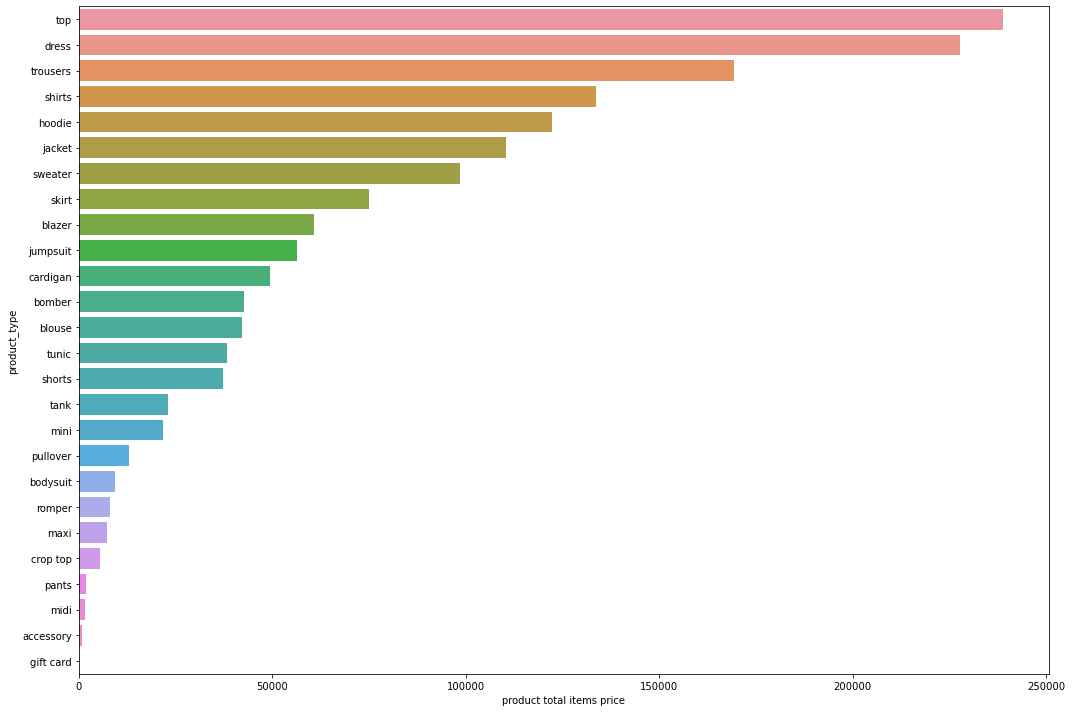

In [22]:
#fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 10), gridspec_kw={'height_ratios': [1, 9]})
fig, ax2 = plt.subplots(figsize=(15, 10))

#sns.boxplot(data=ord_item, x='price', ax=ax1)
#ax1.set_xlabel('overall item price')
sns.barplot(data=(pd.merge(products, 
                           ord_item, 
                           on='product_id')
                  .groupby(['product_type'])
                  .apply(lambda x: (x['quantity'] * x['price']).sum())
                  .reset_index()
                  .rename(columns={0:'total_price'})
                  .sort_values(by=['total_price'], ascending=False)), 
            x='total_price', 
            y='product_type', 
            ax=ax2)

ax2.set_xlabel('product total items price')
fig.tight_layout();

#### Transactions:

In [23]:
temp = pd.merge(orders, transactions, on='order_id')[['total_price', 'transaction_amount', 'transaction_kind', 'transaction_status']]
print('Order total price == transaction price? There are {} not equal.'.format(temp.loc[lambda x: x['total_price'] != x['transaction_amount']].shape[0]))
temp.loc[lambda x: x['total_price'] != x['transaction_amount']]['transaction_kind'].value_counts()

Order total price == transaction price? There are 3306 not equal.


refund           2831
sale              452
authorization      12
capture             7
void                4
Name: transaction_kind, dtype: int64

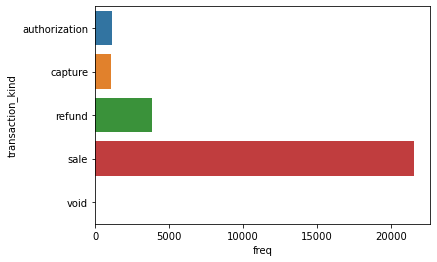

In [24]:
sns.barplot(data=temp.groupby(['transaction_kind'])['transaction_amount'].count().reset_index().rename(columns={'transaction_amount':'freq'}), y='transaction_kind', x='freq');

### Sales Trend Analysis

* Sales trend by daily traffic

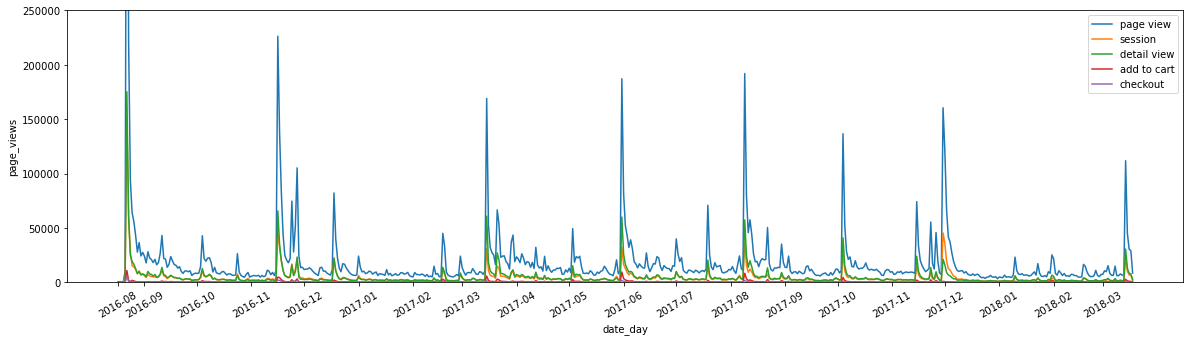

In [25]:
sales_trend_by_traffic = traffic.copy()
sales_trend_by_traffic['y_m'] = sales_trend_by_traffic['date_day'].apply(lambda x: x[:7])
fig, ax = plt.subplots(figsize=(20, 5))
plt.ylim((0, 250000))
# pageview - time
sns.lineplot(data=sales_trend_by_traffic.sort_values(by=['date_day']), x='date_day', y='page_views', ax=ax, label='page view')
# sessions - time
sns.lineplot(data=sales_trend_by_traffic.sort_values(by=['date_day']), x='date_day', y='sessions', ax=ax, label='session')
# prduct detail view - time
sns.lineplot(data=sales_trend_by_traffic.sort_values(by=['date_day']), x='date_day', y='product_detail_views', ax=ax, label='detail view')
# product add to cart - time
sns.lineplot(data=sales_trend_by_traffic.sort_values(by=['date_day']), x='date_day', y='product_adds_to_carts', ax=ax, label='add to cart')
# product checkouts - time
sns.lineplot(data=sales_trend_by_traffic.sort_values(by=['date_day']), x='date_day', y='product_checkouts', ax=ax, label='checkout')

plt.xticks(ticks=sales_trend_by_traffic.reset_index().groupby(['y_m'])['index'].first().tolist(), labels=sales_trend_by_traffic.reset_index().groupby(['y_m'])['index'].first().index.tolist(), rotation=30);

* Sales trend by daily sold items

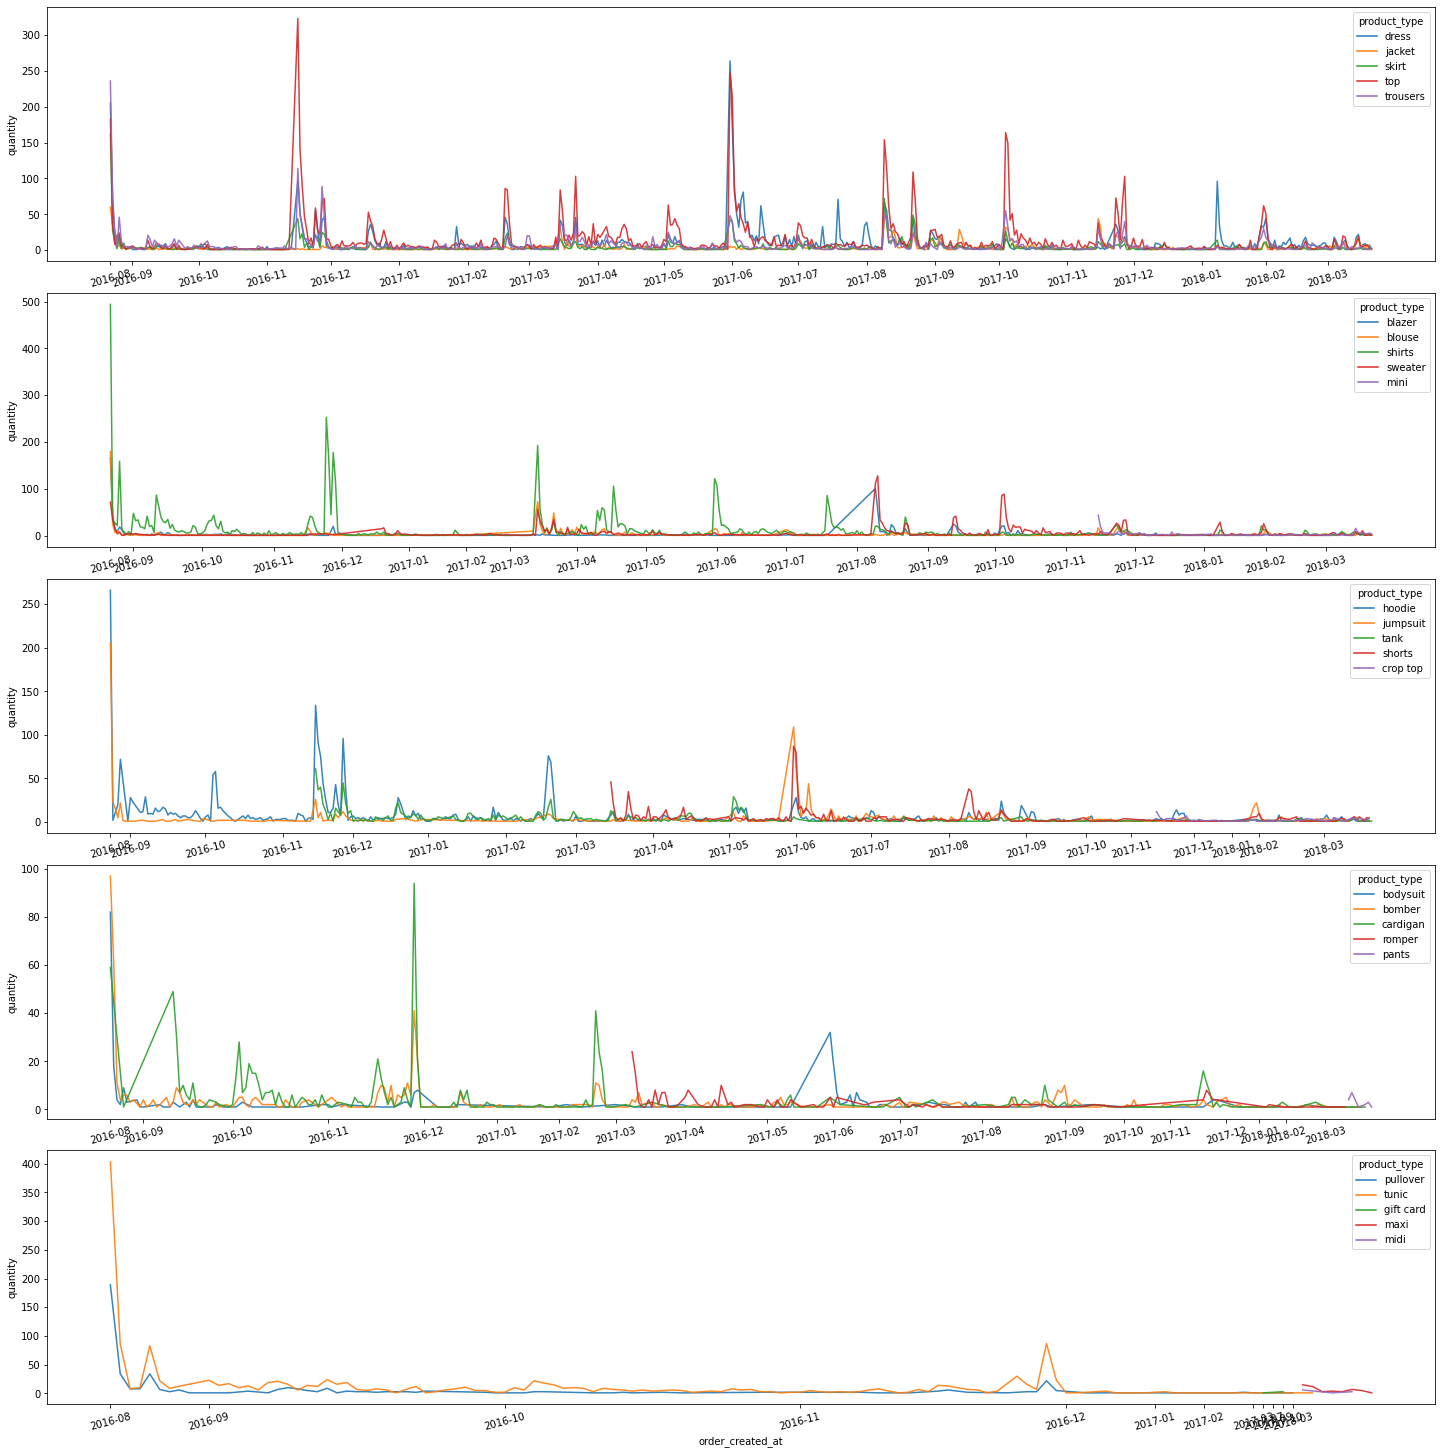

In [26]:
sales_trend_by_item = (pd.merge(orders.loc[lambda x: x['fulfillment_status'] == 'fulfilled'], 
                                transactions.loc[lambda x: x['transaction_status'] == 'success'], 
                                on='order_id')
                       .merge(ord_item, on='order_id')
                       .merge(products, on='product_id')
                       .groupby(['order_created_at', 'product_type'])[['quantity']].sum()
                       .reset_index())
sales_trend_by_item['y_m'] = sales_trend_by_item['order_created_at'].apply(lambda x: x[:7])

# now we split the product types into 5 tiers based on popularity
t1 = ['top', 'dress', 'trousers', 'jacket', 'skirt'] 
t2 = ['shirts', 'sweater', 'blazer', 'mini', 'blouse']
t3 = ['shorts', 'hoodie', 'jumpsuit', 'crop top', 'tank'] 
t4 = ['bodysuit', 'cardigan', 'bomber', 'pants', 'romper']
t5 = ['accessory', 'midi', 'pullover', 'maxi', 'gift card', 'tunic']
      
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, figsize=(20, 20))
fig.tight_layout()
sns.lineplot(data=sales_trend_by_item.loc[lambda x: x['product_type'].isin(t1)], x='order_created_at', y='quantity', hue='product_type', ax=ax1, alpha=0.9)
sns.lineplot(data=sales_trend_by_item.loc[lambda x: x['product_type'].isin(t2)], x='order_created_at', y='quantity', hue='product_type', ax=ax2, alpha=0.9)
sns.lineplot(data=sales_trend_by_item.loc[lambda x: x['product_type'].isin(t3)], x='order_created_at', y='quantity', hue='product_type', ax=ax3, alpha=0.9)
sns.lineplot(data=sales_trend_by_item.loc[lambda x: x['product_type'].isin(t4)], x='order_created_at', y='quantity', hue='product_type', ax=ax4, alpha=0.9)
sns.lineplot(data=sales_trend_by_item.loc[lambda x: x['product_type'].isin(t5)], x='order_created_at', y='quantity', hue='product_type', ax=ax5, alpha=0.9);

def adjust_xticks(data, t, ax, rotation=15):
    xticks = data.loc[lambda x: x['product_type'].isin(t)][['order_created_at', 'y_m']].drop_duplicates().reset_index(drop=True).reset_index().groupby(['y_m'])['index'].first().tolist()
    xticklabels = data.loc[lambda x: x['product_type'].isin(t)]['y_m'].unique().tolist()
    data = data.reset_index().loc[lambda x: x['product_type'].isin(t)]
    ax.set_xticks(ticks=xticks)
    ax.set_xticklabels(labels=xticklabels, 
                       rotation=rotation)

adjust_xticks(sales_trend_by_item, t1, ax1)
adjust_xticks(sales_trend_by_item, t2, ax2)
adjust_xticks(sales_trend_by_item, t3, ax3)
adjust_xticks(sales_trend_by_item, t4, ax4)
adjust_xticks(sales_trend_by_item, t5, ax5)

* Sales trend by daily order

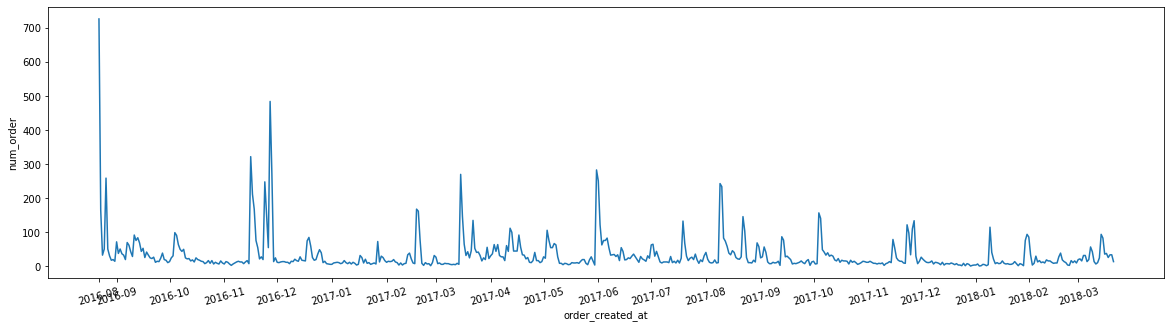

In [27]:
# here again, to make sure each order is closed and have brought revenue, we also make sure the it is not a fully refunded order.
sales_trend_by_order = (pd.merge(transactions, orders, on='order_id')
                        .loc[lambda x: 
                             (x['fulfillment_status'] == 'fulfilled') & 
                             (x['transaction_status'] == 'success') & 
                             (x['financial_status'] != 'refunded')]
                        .groupby(['order_created_at'])['order_id'].nunique()
                        .reset_index()
                        .rename(columns={'order_id':'num_order'}))

sales_trend_by_order['y_m'] = sales_trend_by_order['order_created_at'].apply(lambda x: x[:7])

plt.figure(figsize=(20, 5))
sns.lineplot(data=sales_trend_by_order, x='order_created_at', y='num_order');
plt.xticks(ticks=sales_trend_by_order.reset_index().groupby(['y_m'])['index'].first().tolist(),
           labels=sales_trend_by_order['y_m'].unique().tolist(),
           rotation=15);


* Traffic-order correlation 

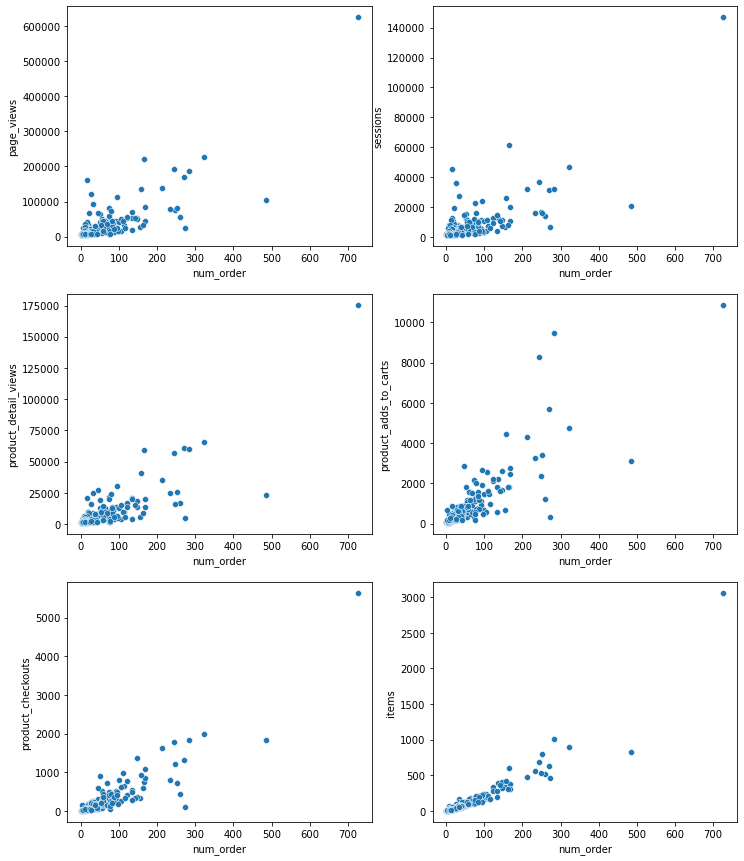

In [28]:
cor_traf_order = (traffic
                  .merge(sales_trend_by_order, 
                         left_on='date_day',
                         right_on='order_created_at')
                  .sort_values(by=['date_day']))

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
sns.scatterplot(data=cor_traf_order, y='page_views', x='num_order', ax=ax1)
sns.scatterplot(data=cor_traf_order, y='sessions', x='num_order', ax=ax2)
sns.scatterplot(data=cor_traf_order, y='product_detail_views', x='num_order', ax=ax3)
sns.scatterplot(data=cor_traf_order, y='product_adds_to_carts', x='num_order', ax=ax4)
sns.scatterplot(data=cor_traf_order, y='product_checkouts', x='num_order', ax=ax5);

cor_traf_item = (sales_trend_by_order
                 .merge(sales_trend_by_item
                        .groupby(['order_created_at'])['quantity'].sum()
                        .reset_index(),
                        on='order_created_at')
                 .sort_values(by=['order_created_at'])
                 .rename(columns={'quantity':'items'}))

sns.scatterplot(data=cor_traf_item, y='items', x='num_order', ax=ax6);

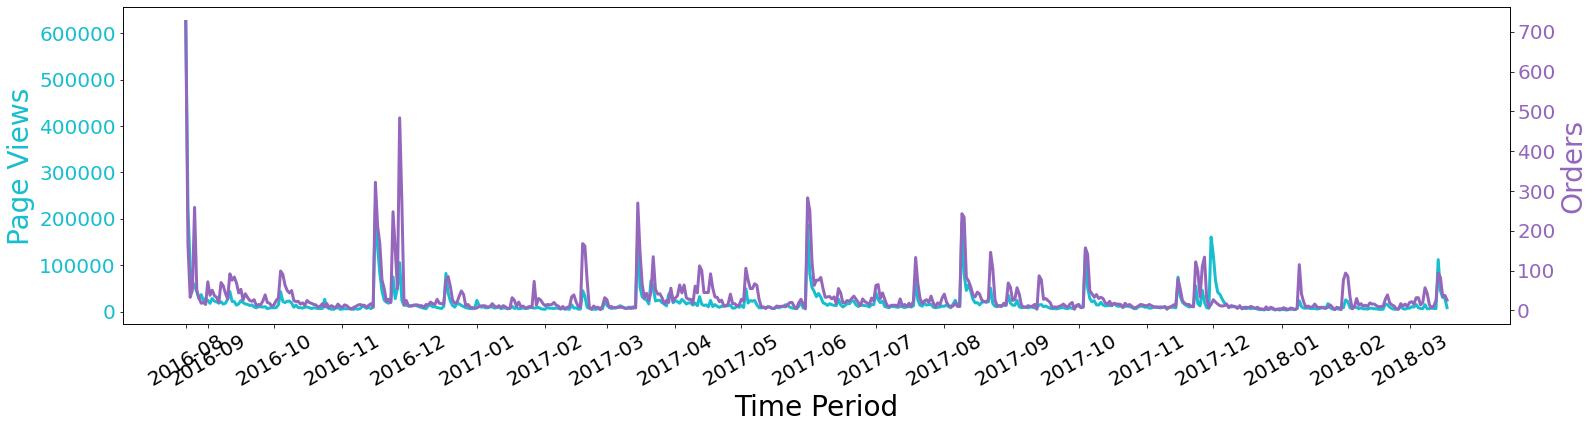

In [29]:
fig, ax1 = plt.subplots(figsize=(20,5))
fig.tight_layout()
#fig.suptitle('The relation between page views and orders', fontsize=40)
color = 'tab:cyan'
ax1.set_xlabel('Time Period', fontsize=28)
ax1.set_ylabel('Page Views', color=color, fontsize=28)
sns.lineplot(data=cor_traf_order, x='order_created_at', y='page_views', color=color, linewidth=3, ax=ax1)
ax1.tick_params(axis='y', labelcolor=color)
xticks = cor_traf_order.reset_index().groupby(['y_m'])['index'].first().tolist()
xlabels = cor_traf_order['y_m'].unique().tolist()
ax1.set_xticks(ticks=xticks)
ax1.set_xticklabels(labels=xlabels, rotation=30)

plt.xticks(size=20)
plt.yticks(size=20)

ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('Orders', color=color, fontsize=28)
sns.lineplot(data=cor_traf_order, x='order_created_at', y='num_order', color=color, linewidth=3, ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xticks(ticks=xticks)
ax2.set_xticklabels(labels=xlabels, rotation=30)
plt.yticks(size=20)

plt.show()

### Sales Funnel Analysis

* Overall Conversion Rates

In [30]:
print('The conversion rate of placed order to page view is only 0.19%.')
print('Through the sales funnel, there is only 10.08% conversion from detail view to add-to-cart, which is relatively the lowest.')
# conversion table
col_order = ['page_views', 'product_detail_views', 'product_adds_to_carts', 'product_checkouts']
overall_conversion = traffic[col_order].sum().reset_index().rename(columns={'index':'sales_funnel', 0:'traffic'}).loc[lambda x: ~x['sales_funnel'].isin(['sessions', 'avg_session_in_s'])]
# orders
overall_orders= orders[['order_id']].count().reset_index().rename(columns={'index':'sales_funnel', 0:'traffic'})
overall_orders.loc[0, 'sales_funnel'] = 'placed_orders'
# closed orders
overall_closed_orders = (orders
                         .loc[lambda x: 
                              (x['order_id'].isin(transactions.loc[lambda x: x['transaction_status'] == 'success', 'order_id'].tolist())) &
                              (x['fulfillment_status'] == 'fulfilled')][['order_id']].count()
                         .reset_index()
                         .rename(columns={'index':'sales_funnel', 0:'traffic'}))
overall_closed_orders.loc[0, 'sales_funnel'] = 'closed_orders'
# profit orders
overall_profit_orders = (orders
                         .loc[lambda x: 
                              (x['order_id'].isin(transactions.loc[lambda x: x['transaction_status'] == 'success', 'order_id'].tolist())) &
                              (x['fulfillment_status'] == 'fulfilled') & 
                              (x['financial_status'] != 'refunded')][['order_id']].count()
                         .reset_index()
                         .rename(columns={'index':'sales_funnel', 0:'traffic'}))
overall_profit_orders.loc[0, 'sales_funnel'] = 'profit_orders'

overall_conversion = pd.concat([overall_conversion, overall_orders, overall_closed_orders, overall_profit_orders], axis=0)
overall_conversion['prev_lvl_traffic'] = overall_conversion['traffic'].shift(1)
overall_conversion['conversion_rate'] = np.round(overall_conversion['traffic'] / overall_conversion['prev_lvl_traffic'], 5)
overall_conversion['conversion_rate_on_pageview'] = np.round(overall_conversion['traffic'] / overall_conversion.loc[lambda x: x['sales_funnel'] == 'page_views', 'traffic'].values, 5)
overall_conversion

The conversion rate of placed order to page view is only 0.19%.
Through the sales funnel, there is only 10.08% conversion from detail view to add-to-cart, which is relatively the lowest.


,sales_funnel,traffic,prev_lvl_traffic,conversion_rate,conversion_rate_on_pageview
0,page_views,10735976,NaN,NaN,1.00000
1,product_detail_views,2870342,10735976.0,0.26736,0.26736
2,product_adds_to_carts,289193,2870342.0,0.10075,0.02694
3,product_checkouts,84464,289193.0,0.29207,0.00787
0,placed_orders,21358,84464.0,0.25287,0.00199
0,closed_orders,19712,21358.0,0.92293,0.00184
0,profit_orders,19127,19712.0,0.97032,0.00178


### Product Analysis

* Product trend correlations (date level)

Total No. product types = 26


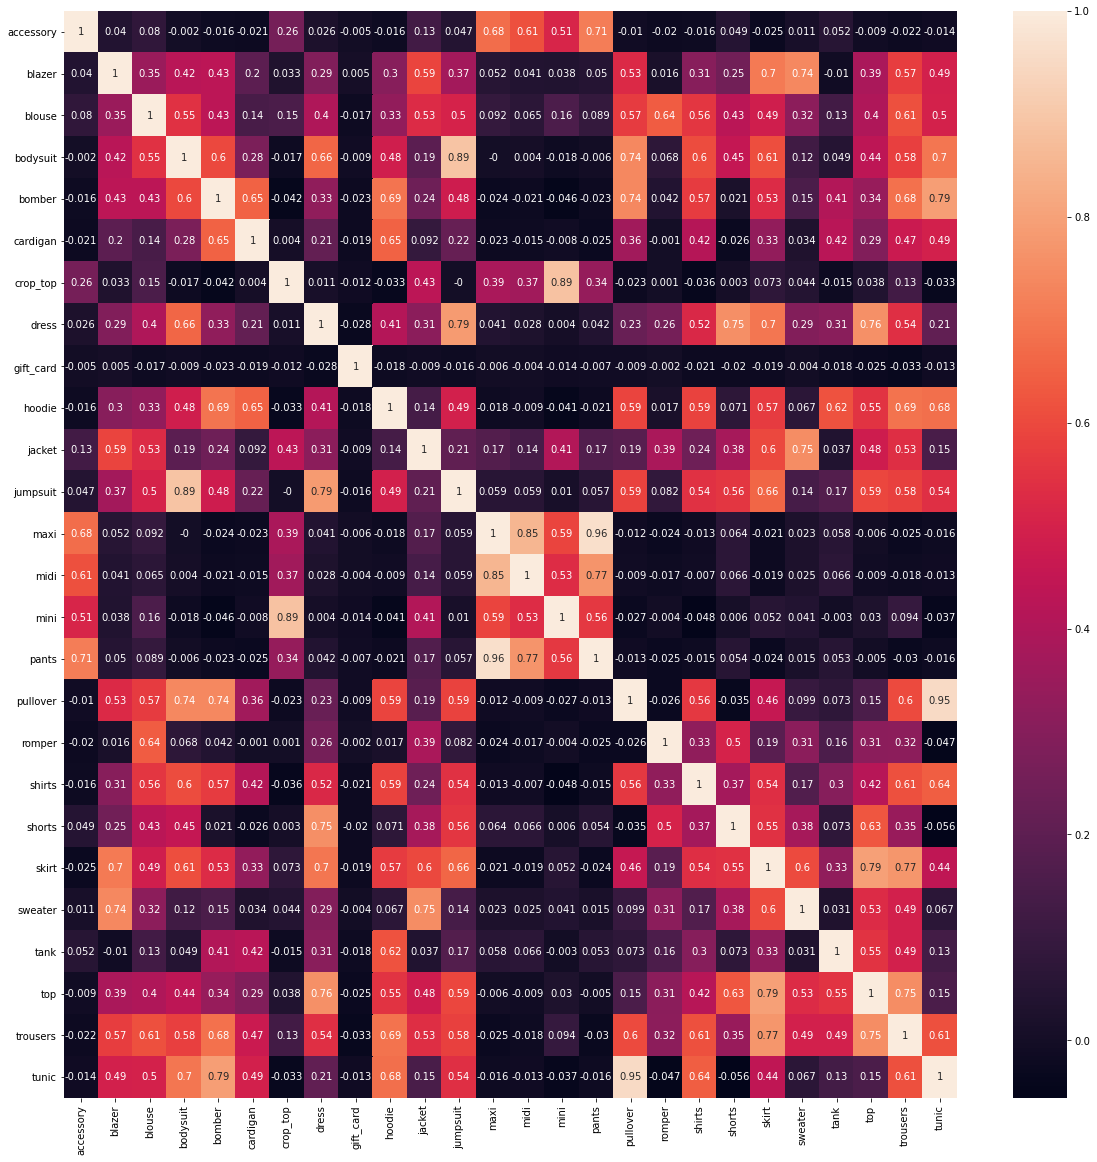

In [31]:
prod_order = (pd.merge(ord_item[['order_id', 'product_id', 'price', 'quantity']],
                       products[['product_id', 'product_type', 'product_created_at','product_published_at']],
                       on='product_id')
              .merge(orders[['order_id', 'order_created_at', 'order_closed_at', 'order_cancelled_at', 'total_price', 'shipping_rate', 'subtotal_price', 'total_discounts', 'total_line_items_price']], 
                     on='order_id')
              .sort_values(by=['order_id', 'product_id']))

print('Total No. product types =', prod_order['product_type'].nunique())
prod_by_t = pd.pivot_table(prod_order,
               index='order_created_at',
               columns='product_type',
               values='quantity',
               aggfunc=lambda x: sum(x),
               fill_value=0).reset_index().sort_values(by=['order_created_at'])
prod_by_t.columns = [col.lower().replace(' ', '_') for col in prod_by_t.columns]

plt.figure(figsize=(20, 20))
sns.heatmap(np.round(prod_by_t.drop(columns=['order_created_at']).corr(), 3), annot=True);

* Product bundling & combo-2 (correlation between product types)(order level)

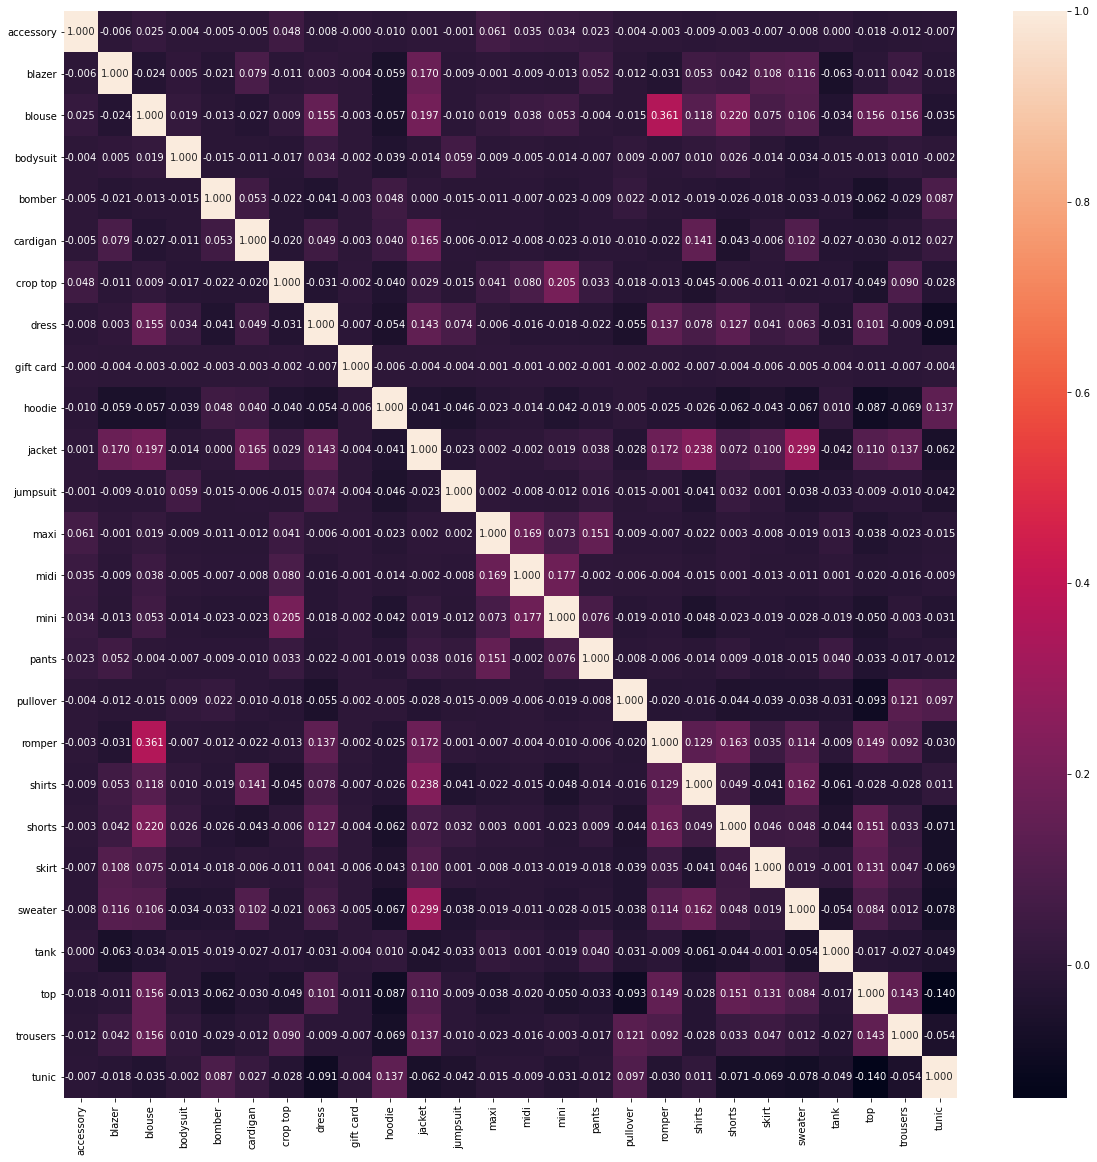

In [32]:
plt.figure(figsize=(20, 20))
sns.heatmap(product_bundle.drop(columns=['item_freq']).corr(), annot=True, annot_kws={'fontsize':10}, fmt='0.3f');

* Market Basket Analysis a.k.a Affinity Analysis (correlation between two products)

In [33]:
concurrence = (pd.merge(ord_item.loc[lambda x: x['fulfillment_status'] == 'fulfilled'], 
                        ord_item.loc[lambda x: x['fulfillment_status'] == 'fulfilled'], 
                        on='order_id')
               .loc[lambda x: x['product_id_x'] != x['product_id_y']]
               .groupby(['product_id_x', 'product_id_y'])['order_id'].count()
               .reset_index()
               .rename(columns={'order_id':'num_concurrence', 
                                'product_id_x':'product_x', 
                                'product_id_y':'product_y'}))

concurrence.head()

,product_x,product_y,num_concurrence
0,1.292763e+10,1.292763e+10,95
1,1.292763e+10,1.292763e+10,17
2,1.292763e+10,1.292763e+10,26
3,1.292763e+10,1.292763e+10,75
4,1.292763e+10,1.292763e+10,9


In [34]:
order_by_product = (ord_item
                    .groupby(['product_id'])['order_id'].count()
                    .reset_index()
                    .rename(columns={'order_id':'num_order'}))
order_by_product.head()

,product_id,num_order
0,1.292763e+10,962
1,1.292763e+10,1112
2,1.292763e+10,144
3,1.292763e+10,462
4,1.292763e+10,1122


In [35]:
basket = pd.merge(concurrence, 
                  order_by_product.rename(columns={'product_id':'product_x'}), 
                  on='product_x')
basket['percentage_purchase_together'] = np.round(basket['num_concurrence'] / basket['num_order'], 4)
basket.sort_values(by=['percentage_purchase_together'], ascending=False).head(10)
basket
basket

,product_x,product_y,num_concurrence,num_order,percentage_purchase_together
0,1.292763e+10,1.292763e+10,95,962,0.0988
1,1.292763e+10,1.292763e+10,17,962,0.0177
2,1.292763e+10,1.292763e+10,26,962,0.0270
3,1.292763e+10,1.292763e+10,75,962,0.0780
4,1.292763e+10,1.292763e+10,9,962,0.0094
...,...,...,...,...,...
14863,1.192348e+12,1.183022e+12,1,7,0.1429
14864,1.192348e+12,1.183022e+12,1,7,0.1429
14865,1.192348e+12,1.183023e+12,2,7,0.2857
14866,1.192348e+12,1.183023e+12,1,7,0.1429


### Promotion Analysis

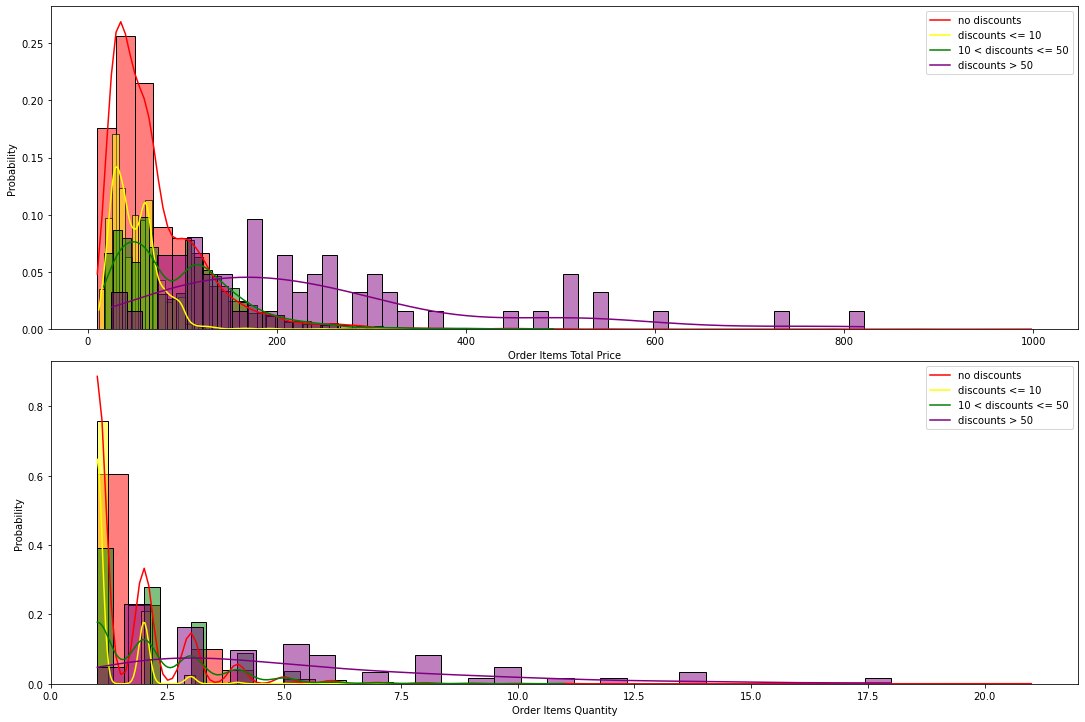

In [36]:
target_order_ids = np.intersect1d(orders.loc[lambda x: 
                                             (x['financial_status'] != 'refunded') & 
                                             (x['fulfillment_status'] == 'fulfilled'), 'order_id'].tolist(), 
                                  transactions.loc[lambda x: x['transaction_status'] == 'success', 'order_id'].tolist()) 

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
fig.tight_layout()
sns.histplot(orders.loc[lambda x: x['order_id'].isin(target_order_ids)].loc[lambda x: x['total_discounts'] == 0]['total_line_items_price'], ax=ax1, bins=50, stat='probability', color='red', label='no discounts', kde=True);
sns.histplot(orders.loc[lambda x: x['order_id'].isin(target_order_ids)].loc[lambda x: (x['total_discounts'] > 0) & (x['total_discounts'] <= 10)]['total_line_items_price'], ax=ax1, bins=50, stat='probability', color='yellow', label='discounts <= 10', kde=True);
sns.histplot(orders.loc[lambda x: x['order_id'].isin(target_order_ids)].loc[lambda x: (x['total_discounts'] > 10) & (x['total_discounts'] <= 50)]['total_line_items_price'], ax=ax1, bins=50, stat='probability', color='green', label='10 < discounts <= 50', kde=True);
sns.histplot(orders.loc[lambda x: x['order_id'].isin(target_order_ids)].loc[lambda x: x['total_discounts'] > 50]['total_line_items_price'], ax=ax1, bins=50, stat='probability', color='purple', label='discounts > 50', kde=True);
ax1.legend(['no discounts', 'discounts <= 10', '10 < discounts <= 50', 'discounts > 50'])
ax1.set_xlabel('Order Items Total Price')

sns.histplot(prod_order.loc[lambda x: x['order_id'].isin(target_order_ids)].loc[lambda x: x['total_discounts'] == 0].groupby(['order_id'])['quantity'].sum(), ax=ax2, bins=30, stat='probability', color='red', label='no discounts', kde=True);
sns.histplot(prod_order.loc[lambda x: x['order_id'].isin(target_order_ids)].loc[lambda x: (x['total_discounts'] > 0) & (x['total_discounts'] <= 10)].groupby(['order_id'])['quantity'].sum(), ax=ax2, bins=30, stat='probability', color='yellow', label='discounts <= 10', kde=True);
sns.histplot(prod_order.loc[lambda x: x['order_id'].isin(target_order_ids)].loc[lambda x: (x['total_discounts'] > 10) & (x['total_discounts'] <= 50)].groupby(['order_id'])['quantity'].sum(), ax=ax2, bins=30, stat='probability', color='green', label='10 < discounts <= 50', kde=True);
sns.histplot(prod_order.loc[lambda x: x['order_id'].isin(target_order_ids)].loc[lambda x: x['total_discounts'] > 50].groupby(['order_id'])['quantity'].sum(), ax=ax2, bins=30, stat='probability', color='purple', label='discounts > 50', kde=True);
ax2.legend(['no discounts', 'discounts <= 10', '10 < discounts <= 50', 'discounts > 50'])
ax2.set_xlabel('Order Items Quantity');

### Customer Analysis - Churn

* Overall Churn  

In [37]:
orders['y_m'] = orders['order_created_at'].apply(lambda x: x[:7])
overall_churn = orders.groupby(['y_m'])['customer_id'].nunique().reset_index().rename(columns={'customer_id':'current_month_num_customers'}) # consider a customer may place orders at the same day, nunique() is used
overall_churn['previous_month_num_customers'] = overall_churn['current_month_num_customers'].shift(1)
#overall_churn['current_month_1st_day_num_customers'] = pd.Series(orders.groupby(['y_m', 'order_created_at'])['customer_id'].nunique().reset_index().groupby(['y_m'])['customer_id'].first().tolist())
#overall_churn['current_month_last_day_num_customers'] = pd.Series(orders.groupby(['y_m', 'order_created_at'])['customer_id'].nunique().reset_index().groupby(['y_m'])['customer_id'].last().tolist())

overall_churn['num_churns'] = overall_churn['previous_month_num_customers'] - overall_churn['current_month_num_customers']
overall_churn['churn_rate'] = overall_churn['num_churns'] / overall_churn['previous_month_num_customers']
overall_churn

,y_m,current_month_num_customers,previous_month_num_customers,num_churns,churn_rate
0,2016-08,1433,NaN,NaN,NaN
1,2016-09,1214,1433.0,219.0,0.152826
2,2016-10,823,1214.0,391.0,0.322076
3,2016-11,2353,823.0,-1530.0,-1.859052
4,2016-12,748,2353.0,1605.0,0.682108
5,2017-01,488,748.0,260.0,0.347594
6,2017-02,759,488.0,-271.0,-0.555328
7,2017-03,1251,759.0,-492.0,-0.648221
8,2017-04,1237,1251.0,14.0,0.011191
9,2017-05,1060,1237.0,177.0,0.143088


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



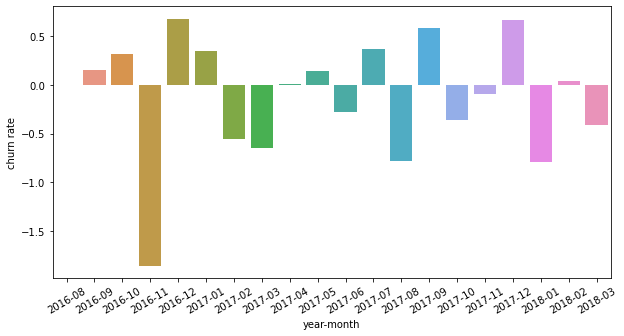

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(overall_churn['y_m'], overall_churn['churn_rate'])
#plt.title('Churn rate over month', size=20)
ax.tick_params(axis='x', rotation=30)
plt.ylabel('churn rate')
plt.xlabel('year-month');

* Customer-level Churn (Customers without purchase in the current and previous 3 months is called churn)

In [39]:
customer_journey = []
for cus in customers['customer_id'].unique():
    cus_1st_day = customers.loc[lambda x: x['customer_id'] == cus, 'customer_created_at'].values[0]
    for t in orders.loc[lambda x: x['order_created_at'] >= cus_1st_day]['order_created_at'].unique():
        customer_journey.append([cus, t])
        
customer_journey = pd.DataFrame(customer_journey, columns=['customer_id', 'date'])
customer_journey = pd.merge(customers[['customer_id', 'customer_created_at']], customer_journey, on='customer_id')

customer_order = (pd.merge(customer_journey, 
                           orders, 
                           left_on=['customer_id', 'date'],
                           right_on=['customer_id', 'order_created_at'], 
                           how='left')
                  [['customer_id', 'customer_created_at', 'date', 'order_created_at']]
                  .sort_values(by=['order_created_at', 'customer_id']))

customer_order['y_m'] = customer_order['date'].apply(lambda x: x[:7] if type(x) == str else x)
customer_order

,customer_id,customer_created_at,date,order_created_at,y_m
4599662,8683754719,2016-08-21,2016-08-21,2016-08-21,2016-08
4600241,8686224991,2016-08-22,2016-08-22,2016-08-22,2016-08
4600242,8686224991,2016-08-22,2016-08-22,2016-08-22,2016-08
1732,8686915935,2016-08-22,2016-08-22,2016-08-22,2016-08
4601976,8686924319,2016-08-22,2016-08-22,2016-08-22,2016-08
...,...,...,...,...,...
17336275,1063374165501,2018-03-21,2018-03-21,NaN,2018-03
17336276,1063374165501,2018-03-21,2018-03-22,NaN,2018-03
17336278,1063472010749,2018-03-21,2018-03-22,NaN,2018-03
17336280,1063480464893,2018-03-21,2018-03-22,NaN,2018-03


In [40]:
customer_order['is_purchased'] = customer_order['order_created_at'].apply(lambda x: 1 if type(x) == str else 0)
customer_churn = customer_order.groupby(['customer_id', 'y_m']).agg({'customer_created_at':'first', 'is_purchased':'sum'}).rename(columns={'is_purchased':'num_order'}).reset_index()
customer_churn['prev_num_order'] = customer_churn.groupby(['customer_id']).apply(lambda x: x['num_order'].shift(1)).tolist()
customer_churn['2nd_prev_num_order'] = customer_churn.groupby(['customer_id']).apply(lambda x: x['num_order'].shift(2)).tolist()
customer_churn['3rd_prev_num_order'] = customer_churn.groupby(['customer_id']).apply(lambda x: x['num_order'].shift(3)).tolist()

customer_churn['is_current_month_active'] = customer_churn['num_order'].apply(lambda x: 1 if x > 0 else 0)
customer_churn['is_prev_month_active'] = customer_churn['prev_num_order'].apply(lambda x: 1 if x > 0 else 0)
customer_churn['is_2nd_prev_month_active'] = customer_churn['2nd_prev_num_order'].apply(lambda x: 1 if x > 0 else 0)
customer_churn['is_3rd_prev_month_active'] = customer_churn['3rd_prev_num_order'].apply(lambda x: 1 if x > 0 else 0)

In [41]:
customer_churn = customer_churn.drop(columns=['status'], errors='ignore')
customer_churn['total_num_order'] = pd.Series(customer_churn.groupby(['customer_id'])['num_order'].cumsum().tolist())

customer_churn.loc[lambda x: 
                   (x['is_current_month_active'] == 0) & 
                   (x['is_prev_month_active'] == 0) & 
                   (x['is_2nd_prev_month_active'] == 0) & 
                   (x['is_3rd_prev_month_active'] == 0), 'status'] = 'churn'

customer_churn.loc[lambda x: 
                   (x['is_current_month_active'] == 1) | 
                   (x['is_prev_month_active'] == 1) |
                   (x['is_2nd_prev_month_active'] == 1) |
                   (x['is_3rd_prev_month_active'] == 1), 'status'] = 'active'

customer_churn.loc[lambda x: 
                   (x['is_current_month_active'] == 1) & 
                   (x['is_prev_month_active'] == 1) &
                   (x['is_2nd_prev_month_active'] == 1) &
                   (x['is_3rd_prev_month_active'] == 1), 'status'] = 'loyal'

customer_churn.loc[lambda x: x['total_num_order'] == 0, 'status'] = 'have_not_purchased'

customer_churn.head()

,customer_id,y_m,customer_created_at,num_order,prev_num_order,2nd_prev_num_order,3rd_prev_num_order,is_current_month_active,is_prev_month_active,is_2nd_prev_month_active,is_3rd_prev_month_active,total_num_order,status
0,8644299295,2016-08,2016-08-16,0,NaN,NaN,NaN,0,0,0,0,0,have_not_purchased
1,8644299295,2016-09,2016-08-16,0,0.0,NaN,NaN,0,0,0,0,0,have_not_purchased
2,8644299295,2016-10,2016-08-16,0,0.0,0.0,NaN,0,0,0,0,0,have_not_purchased
3,8644299295,2016-11,2016-08-16,0,0.0,0.0,0.0,0,0,0,0,0,have_not_purchased
4,8644299295,2016-12,2016-08-16,0,0.0,0.0,0.0,0,0,0,0,0,have_not_purchased


In [42]:
churn = pd.pivot_table(customer_churn[['y_m', 'status']],
                       index=['y_m'],
                       columns=['status'],
                       aggfunc=lambda x: len(x),
                       fill_value=0).reset_index()
churn

status,y_m,active,churn,have_not_purchased,loyal
0,2016-08,1433,0,8784,0
1,2016-09,2524,0,10681,0
2,2016-10,3260,0,12523,0
3,2016-11,5274,0,14655,4
4,2016-12,4749,1121,15567,1
5,2017-01,4062,2097,16069,1
6,2017-02,3896,2700,16488,6
7,2017-03,2990,4585,18003,5
8,2017-04,3431,5092,19042,5
9,2017-05,3888,5355,20047,7


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



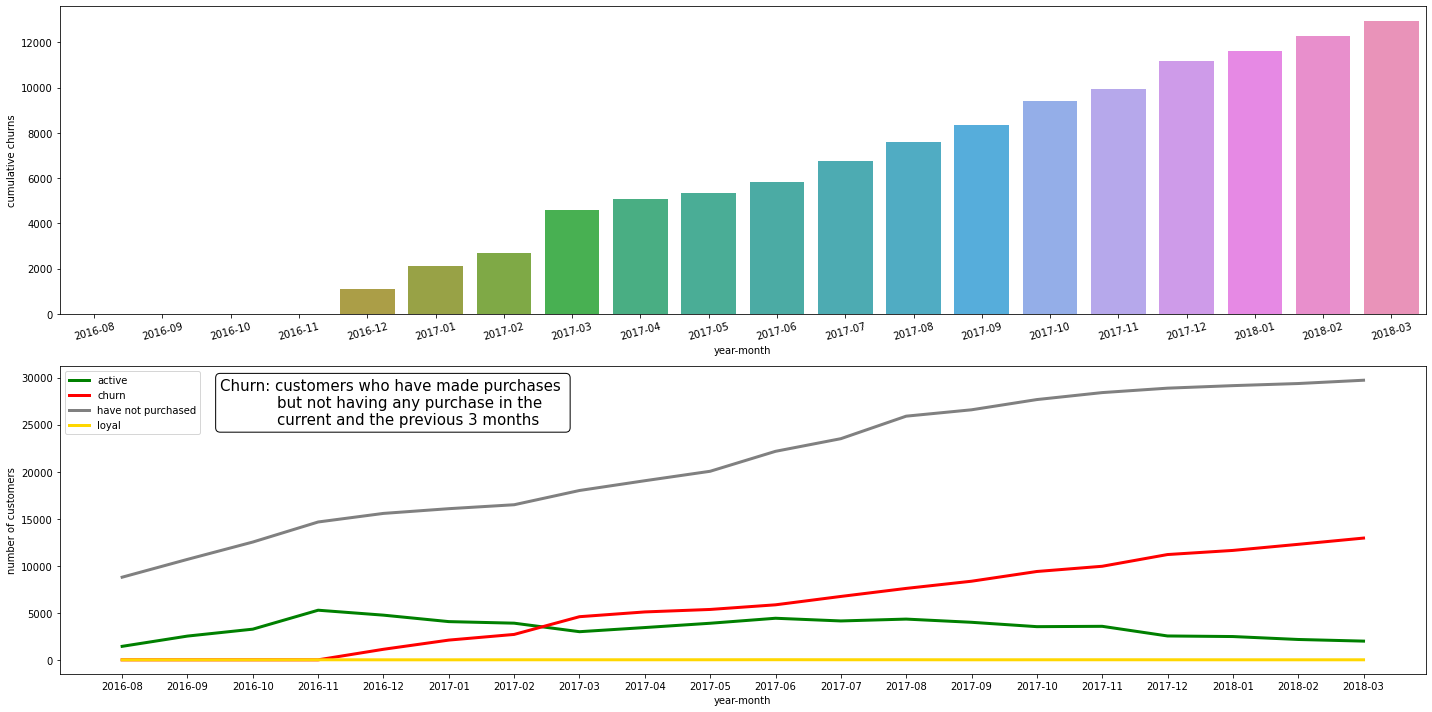

In [68]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

sns.barplot(churn['y_m'], churn['churn'], ax=ax1)
plt.text(x=1.5, 
         y=25000, 
         s='Churn: customers who have made purchases \n            but not having any purchase in the \n            current and the previous 3 months', 
         fontfamily='fantasy', 
         fontsize=15, 
         fontweight=5,
         bbox={'boxstyle':'round', 'facecolor':'none', 'edgecolor':'black'})
ax1.tick_params(axis='x', rotation=15)
ax1.set_ylabel('cumulative churns')
ax1.set_xlabel('year-month');

sns.lineplot(data=churn, x='y_m', y='active', ax=ax2, label='active', linewidth=3, color='green')
sns.lineplot(data=churn, x='y_m', y='churn', ax=ax2, label='churn', linewidth=3, color='red')
sns.lineplot(data=churn, x='y_m', y='have_not_purchased', ax=ax2, label='have not purchased', linewidth=3, color='grey')
sns.lineplot(data=churn, x='y_m', y='loyal', ax=ax2, label='loyal', linewidth=3, color='gold')
ax2.set_ylabel('number of customers')
ax2.set_xlabel('year-month')
fig.tight_layout();

### Customer Analysis - Retention

In [44]:
customer_churn.head()

,customer_id,y_m,customer_created_at,num_order,prev_num_order,2nd_prev_num_order,3rd_prev_num_order,is_current_month_active,is_prev_month_active,is_2nd_prev_month_active,is_3rd_prev_month_active,total_num_order,status
0,8644299295,2016-08,2016-08-16,0,NaN,NaN,NaN,0,0,0,0,0,have_not_purchased
1,8644299295,2016-09,2016-08-16,0,0.0,NaN,NaN,0,0,0,0,0,have_not_purchased
2,8644299295,2016-10,2016-08-16,0,0.0,0.0,NaN,0,0,0,0,0,have_not_purchased
3,8644299295,2016-11,2016-08-16,0,0.0,0.0,0.0,0,0,0,0,0,have_not_purchased
4,8644299295,2016-12,2016-08-16,0,0.0,0.0,0.0,0,0,0,0,0,have_not_purchased


In [79]:
customer_churn['cohert'] = customer_churn['customer_created_at'].apply(lambda x: x[:7])
retention = pd.pivot_table(customer_churn.loc[lambda x: x['num_order'] != 0], # here we drop all the customers who didn't place order in certain months
                           index=['y_m'],
                           columns=['cohert'],
                           values=['customer_id'],
                           aggfunc=lambda x: x.nunique(),
                           fill_value=0).reset_index()
retention.columns = ['y_m'] + [col[1] for col in retention.columns[1:]]
retention

,y_m,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,...,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
0,2016-08,1433,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2016-09,470,744,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2016-10,171,73,579,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2016-11,536,136,135,1546,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2016-12,114,34,22,70,508,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2017-01,95,32,24,78,49,210,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2017-02,162,63,49,96,39,30,320,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2017-03,184,45,28,65,25,20,21,863,0,...,0,0,0,0,0,0,0,0,0,0
8,2017-04,148,53,30,62,21,16,24,161,722,...,0,0,0,0,0,0,0,0,0,0
9,2017-05,179,39,23,83,20,17,24,64,52,...,0,0,0,0,0,0,0,0,0,0


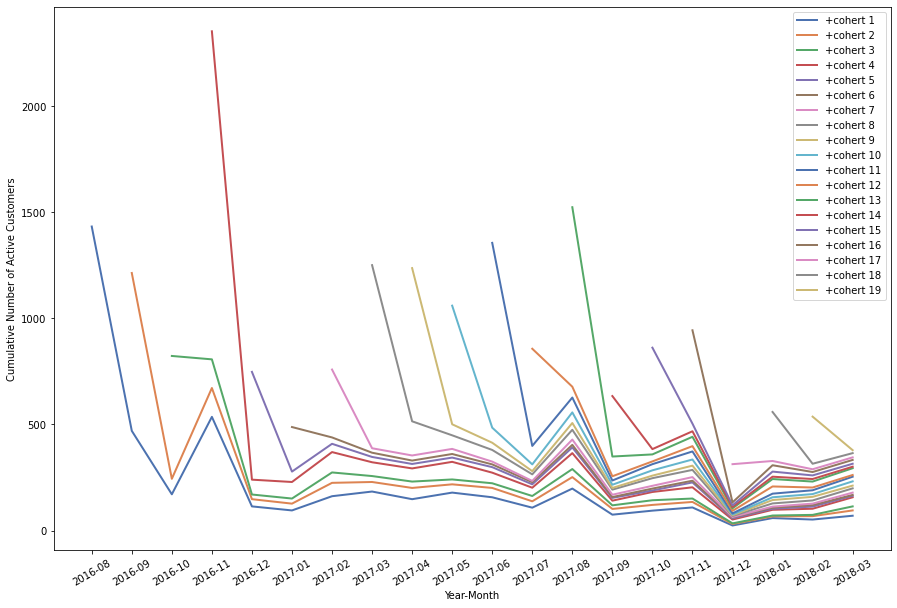

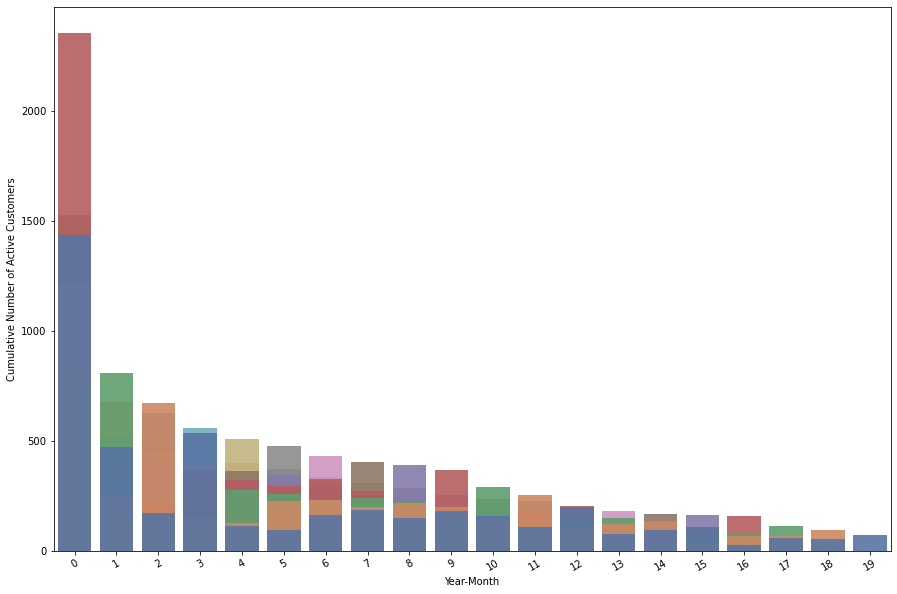

In [131]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.xticks(ticks=np.arange(len(retention['y_m'])), labels=retention['y_m'], rotation=30)
plt.xlabel('Year-Month')
plt.ylabel('Cumulative Number of Active Customers')

retentions_data_list = []
for i in range(2, len(retention.columns)):
    data = retention.iloc[i-2:, 1:i]
    retentions_data_list.append(data)
    sns.lineplot(x=data.index, y=data.sum(axis=1), color=sns.color_palette("deep", n_colors=30)[i-2], label='+cohert ' + str(i - 1), linewidth=2)

fig, ax2 = plt.subplots(figsize=(15, 10)) 
ax2.set_xlim((-1, 20))
plt.xticks(ticks=np.arange(len(retention['y_m'])), labels=retention['y_m'], rotation=30)
plt.xlabel('Year-Month')
plt.ylabel('Cumulative Number of Active Customers')

retentions_data_list.reverse()
for i, data in enumerate(retentions_data_list):
    sns.barplot(x=data.index, y=data.sum(axis=1), color=sns.color_palette("deep", n_colors=30)[18 - i], label='+cohert ' + str(i+1), linewidth=2, alpha=0.9)


In [47]:
customer_retention = pd.DataFrame(retention['y_m'])
for i, col in enumerate(retention.columns[1:]):
    data = retention.loc[i:, col].reset_index(drop=True)
    customer_retention = pd.concat([customer_retention, data], axis=1)

for col in customer_retention.columns[1:]:
    if customer_retention[col].max() > 1:
        customer_retention[col] = np.round(customer_retention[col] / customer_retention[col].max(), 4)
customer_retention = customer_retention.drop(columns=['y_m'])
customer_retention

,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0
1,0.3280,0.0981,0.2332,0.0453,0.0965,0.1429,0.0656,0.1866,0.0720,0.1270,0.0999,0.1114,0.1099,0.0877,0.0753,0.0318,0.1111,0.1126,0.0631,NaN
2,0.1193,0.1828,0.0380,0.0505,0.0768,0.0952,0.0750,0.0742,0.0471,0.0572,0.0804,0.0437,0.0390,0.0912,0.0167,0.0682,0.0722,0.0866,NaN,NaN
3,0.3740,0.0457,0.0415,0.0621,0.0492,0.0762,0.0750,0.0637,0.0208,0.0894,0.0230,0.0284,0.0520,0.0211,0.0502,0.0364,0.0667,NaN,NaN,NaN
4,0.0796,0.0430,0.0846,0.0420,0.0413,0.0810,0.0406,0.0359,0.0443,0.0268,0.0333,0.0546,0.0142,0.0386,0.0356,0.0409,NaN,NaN,NaN,NaN
5,0.0663,0.0847,0.0484,0.0401,0.0394,0.0619,0.0188,0.0533,0.0111,0.0447,0.0436,0.0262,0.0414,0.0421,0.0293,NaN,NaN,NaN,NaN,NaN
6,0.1130,0.0605,0.0518,0.0537,0.0512,0.0476,0.0781,0.0278,0.0166,0.0519,0.0057,0.0742,0.0331,0.0246,NaN,NaN,NaN,NaN,NaN,NaN
7,0.1284,0.0712,0.0397,0.0323,0.0315,0.0571,0.0344,0.0417,0.0277,0.0072,0.0195,0.0284,0.0378,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.1033,0.0524,0.0380,0.0252,0.0531,0.0190,0.0406,0.0394,0.0042,0.0233,0.0207,0.0175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.1249,0.0591,0.0432,0.0485,0.0256,0.0429,0.0531,0.0058,0.0222,0.0233,0.0253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


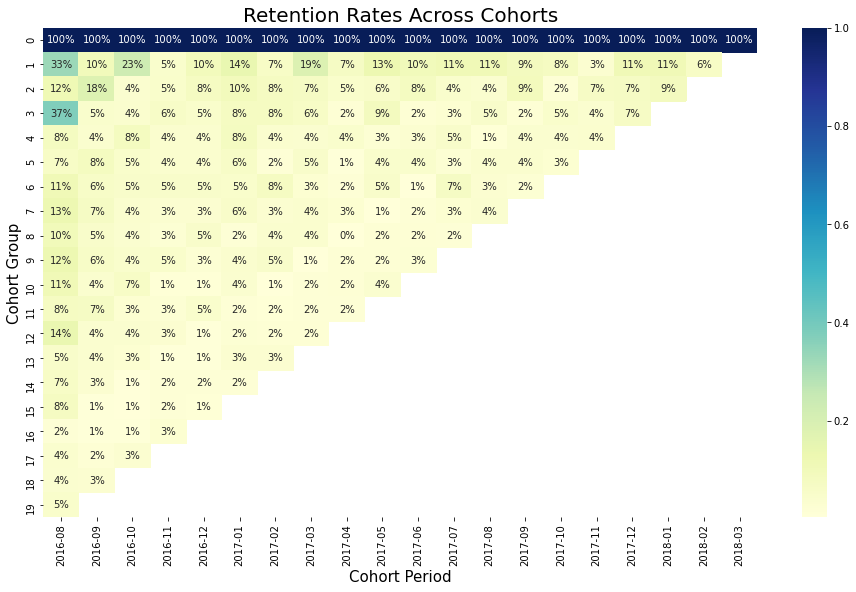

In [48]:
fig = plt.figure(figsize=(16,9))
fig.tight_layout()
ax = sns.heatmap(customer_retention, annot=True, cmap="YlGnBu", fmt='.0%')

ax.set_xlabel('Cohort Period', fontsize = 15)
ax.set_ylabel('Cohort Group', fontsize = 15)

ax.set_title('Retention Rates Across Cohorts', fontsize = 20)
plt.show()

### Customer Analysis - RFM

* In order to improve the retention rate, we need to get a better understanding of the old customers.
* Instead of analyzing the entire customer base as a whole, it’s better to segment them into homogeneous groups, understand the traits of each group, and engage them with relevant campaigns rather than segmenting on just customer age or geography.
* One of the most popular, easy-to-use, and effective segmentation methods to enable marketers to analyze customer behavior is RFM analysis.

In [49]:
rfm = (orders
       .groupby(['customer_id'])
       .agg({'order_created_at': lambda x: (orders['order_created_at'].astype('datetime64[ns]').dt.date.max() - x.astype('datetime64[ns]').dt.date.max()).days,
             'order_id': lambda x: len(x),
             'total_price': lambda x: x.sum()})
       .rename(columns={'order_created_at':'recency',
                        'order_id':'frequency',
                        'total_price':'monetary'})
       .reset_index()
       .loc[lambda x: x['customer_id'] != 280479208957] # this is a wierd: customer 280479208957 made 355 orders, which is also an outlier
      )

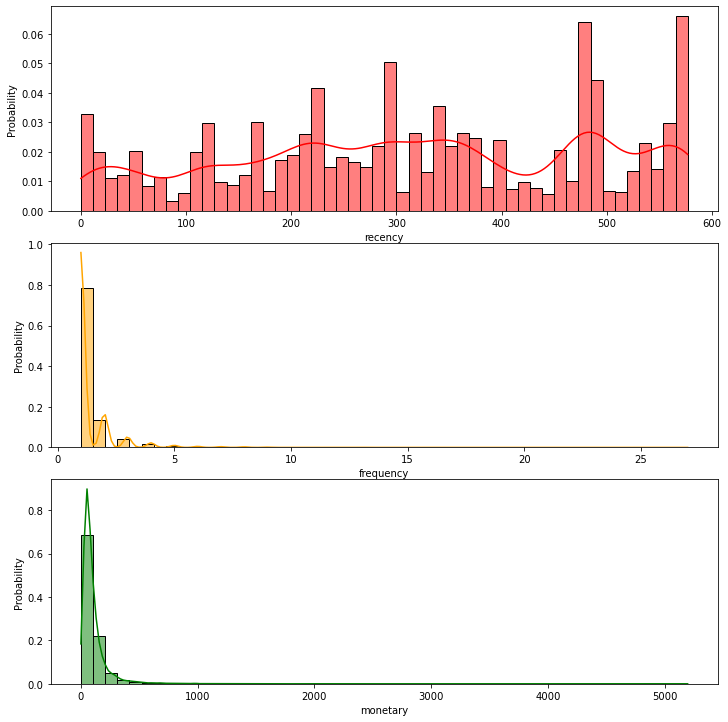

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
fig.tight_layout()
sns.histplot(data=rfm, x='recency', stat='probability', bins=50, kde=True, color='red', ax=ax1)
sns.histplot(data=rfm, x='frequency', stat='probability', bins=50, kde=True, color='orange', ax=ax2)
sns.histplot(data=rfm, x='monetary', stat='probability', bins=50, kde=True, color='green', ax=ax3);

In [51]:
def rfm_to_score(df, col, q=[0, 0.25, 0.5, 0.75, 1], labels=[1, 2, 3, 4]):
    """Convert RFM to scores. """
    if col == 'recency':
        return pd.qcut(-df[col], q=q, labels=labels)
    elif col == 'monetary':
        return pd.qcut(df[col], q=q, labels=labels)
    elif col == 'frequency':
        return df[col].apply(lambda x: 1 if x <= 1 else 4)
    else: 
        print('column not applied...')
        pass

rfm['R'] = rfm_to_score(rfm, col='recency')
rfm['F'] = rfm_to_score(rfm, col='frequency')
rfm['M'] = rfm_to_score(rfm, col='monetary')

rfm['RFMGroup'] = rfm['R'].astype(str) + '/' + rfm['F'].astype(str) + '/' + rfm['M'].astype(str)
rfm['RFMScore'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm['loyalty_by_rfm'] = pd.qcut(rfm['RFMScore'], q=[0, 0.25, 0.5, 0.75, 1], labels=['bronze', 'silver', 'gold', 'platinum'])
rfm.head()

,customer_id,recency,frequency,monetary,R,F,M,RFMGroup,RFMScore,loyalty_by_rfm
0,8683754719,357,10,875.80,2,4,4,2/4/4,10,platinum
1,8686224991,415,10,286.33,2,4,4,2/4/4,10,platinum
2,8686913503,293,3,140.28,3,4,4,3/4/4,11,platinum
3,8686915935,577,1,131.10,1,1,4,1/1/4,6,silver
4,8686924319,577,1,91.12,1,1,3,1/1/3,5,bronze


In [52]:
rfm.loc[rfm['R'] == 4].head(10)

,customer_id,recency,frequency,monetary,R,F,M,RFMGroup,RFMScore,loyalty_by_rfm
8,8687301023,169,3,295.64,4,4,4,4/4/4,12,platinum
12,8687329311,49,2,155.32,4,4,4,4/4/4,12,platinum
15,8687346591,32,6,377.30,4,4,4,4/4/4,12,platinum
22,8687529503,122,1,78.18,4,1,3,4/1/3,8,gold
27,8687623647,130,7,579.07,4,4,4,4/4/4,12,platinum
34,8687642079,127,2,88.77,4,4,3,4/4/3,11,platinum
35,8687646303,121,16,1573.95,4,4,4,4/4/4,12,platinum
55,8687899167,176,2,165.08,4,4,4,4/4/4,12,platinum
59,8687947103,48,3,386.57,4,4,4,4/4/4,12,platinum
61,8687965599,7,4,308.97,4,4,4,4/4/4,12,platinum


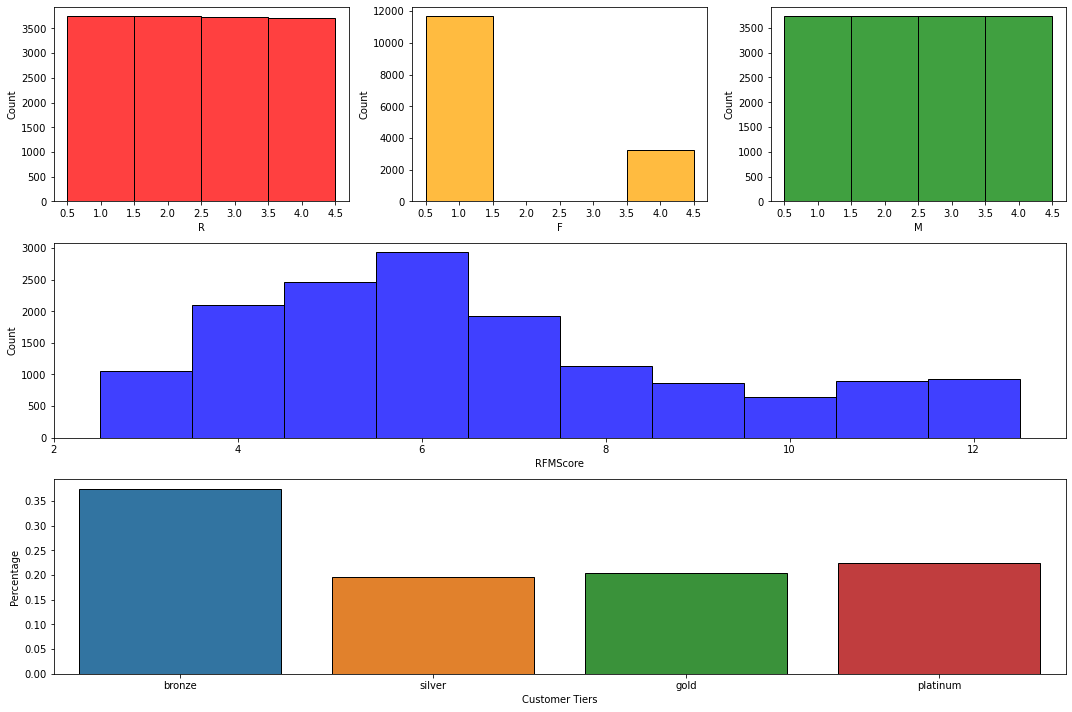

In [53]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
sns.histplot(data=rfm, x='R', bins=50, color='red', ax=ax1, binwidth=0.5, discrete=True)
sns.histplot(data=rfm, x='F', bins=50, color='orange', ax=ax2, binwidth=0.5, discrete=True)
sns.histplot(data=rfm, x='M', bins=50, color='green', ax=ax3, binwidth=0.5, discrete=True)
ax4 = fig.add_subplot(3, 1, 2)
sns.histplot(data=rfm, x='RFMScore', bins=50, color='blue', ax=ax4, discrete=True)
ax5 = fig.add_subplot(3, 1, 3)
sns.barplot(data=rfm['loyalty_by_rfm'].value_counts(normalize=True).reset_index(), x='index', y='loyalty_by_rfm', ax=ax5, edgecolor=(0, 0, 0))
ax5.set_xlabel('Customer Tiers')
ax5.set_ylabel('Percentage')
fig.tight_layout();

### Customer Analysis - Segmentation by Clustering

In [54]:
customer_seg = rfm.copy()

In [55]:
# avg. number of days placing order 
customer_seg = customer_seg.drop(columns=['avg_num_days_to_place_another_order'], errors='ignore')
customer_order['order_created_at'] = customer_order['order_created_at'].astype('datetime64[ns]')
customer_order['prev_order_created_at'] = customer_order.sort_values(by=['customer_id', 'order_created_at']).groupby(['customer_id'])['order_created_at'].apply(lambda x: x.shift(1))
customer_order['num_days_btwn_orders']  = (customer_order['order_created_at'] - customer_order['prev_order_created_at']).dt.days

customer_seg = rfm.copy()
customer_seg = customer_seg.merge(customer_order
                                  .groupby(['customer_id'])['num_days_btwn_orders'].mean()
                                  .reset_index()
                                  .rename(columns={'num_days_btwn_orders':'avg_num_days_to_place_another_order'})
                                  .fillna(0),
                                  on='customer_id')

customer_seg['avg_num_days_to_place_another_order'] = customer_seg['avg_num_days_to_place_another_order'].astype(int)

In [56]:
# num refund
customer_seg = customer_seg.drop(columns=['num_refund'], errors='ignore')
customer_seg = (
customer_seg.merge(pd.merge(customer_order, 
                            orders[['customer_id', 'order_id']], 
                            on='customer_id')
                   .merge(transactions[['order_id', 'transaction_amount', 'transaction_kind', 'transaction_status']], 
                          on='order_id')
                   .loc[lambda x: x['transaction_kind'] == 'refund']
                   .groupby(['customer_id'])['order_id'].nunique()
                   .reset_index()
                   .rename(columns={'order_id':'num_refund'}),
                   on='customer_id',
                   how='left')
)
customer_seg['num_refund'] = customer_seg['num_refund'].fillna(0)

In [57]:
# num void or failure
customer_seg = customer_seg.drop(columns=['num_transaction_void_failure'], errors='ignore')
customer_seg = (
customer_seg.merge(pd.merge(customer_order, 
                            orders[['customer_id', 'order_id']], 
                            on='customer_id')
                   .merge(transactions[['order_id', 'transaction_amount', 'transaction_kind', 'transaction_status', 'error_code']], 
                          on='order_id')
                   .loc[lambda x: 
                        (x['transaction_kind'] == 'void') | 
                        (x['transaction_status'].isin(['failure', 'error'])) |
                        (~x['error_code'].isnull())]
                   .groupby(['customer_id'])['order_id'].nunique()
                   .reset_index()
                   .rename(columns={'order_id':'num_transaction_void_failure'}),
                   on='customer_id',
                   how='left')
)
customer_seg['num_transaction_void_failure'] = customer_seg['num_transaction_void_failure'].fillna(0)

In [58]:
customer_seg.head()

,customer_id,recency,frequency,monetary,R,F,M,RFMGroup,RFMScore,loyalty_by_rfm,avg_num_days_to_place_another_order,num_refund,num_transaction_void_failure
0,8683754719,357,10,875.80,2,4,4,2/4/4,10,platinum,24,7.0,2.0
1,8686224991,415,10,286.33,2,4,4,2/4/4,10,platinum,18,3.0,1.0
2,8686913503,293,3,140.28,3,4,4,3/4/4,11,platinum,98,0.0,1.0
3,8686915935,577,1,131.10,1,1,4,1/1/4,6,silver,0,0.0,0.0
4,8686924319,577,1,91.12,1,1,3,1/1/3,5,bronze,0,0.0,0.0


In [59]:
col_list = ['recency', 'frequency', 'monetary', 'avg_num_days_to_place_another_order', 'num_refund', 'num_transaction_void_failure']
std_scaler = StandardScaler()
cluster_data = pd.DataFrame(std_scaler.fit_transform(customer_seg[col_list]), 
                            index=customer_seg.index,
                            columns=col_list)

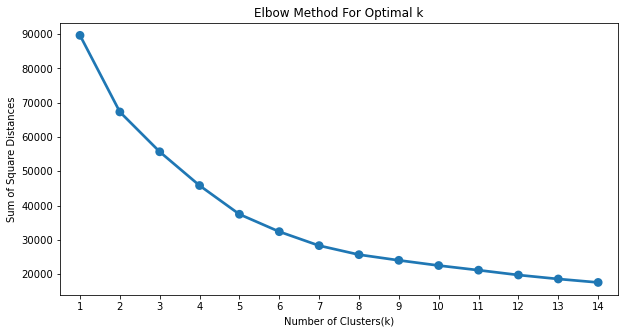

In [60]:
sum_of_sq_dist = {}
for k in range(1,15):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    kmeans = kmeans.fit(cluster_data)
    sum_of_sq_dist[k] = kmeans.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
plt.figure(figsize=(10, 5))
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [25]:
# build the K-Means clustering model
kmeans = KMeans(n_clusters= 5, init= 'k-means++', max_iter= 1000, random_state=42)
kmeans.fit(cluster_data)

customer_seg['cluster'] = kmeans.labels_
customer_seg.head()

NameError: name 'cluster_data' is not defined

In [62]:
customer_seg.head()

,customer_id,recency,frequency,monetary,R,F,M,RFMGroup,RFMScore,loyalty_by_rfm,avg_num_days_to_place_another_order,num_refund,num_transaction_void_failure,cluster
0,8683754719,357,10,875.80,2,4,4,2/4/4,10,platinum,24,7.0,2.0,1
1,8686224991,415,10,286.33,2,4,4,2/4/4,10,platinum,18,3.0,1.0,1
2,8686913503,293,3,140.28,3,4,4,3/4/4,11,platinum,98,0.0,1.0,2
3,8686915935,577,1,131.10,1,1,4,1/1/4,6,silver,0,0.0,0.0,0
4,8686924319,577,1,91.12,1,1,3,1/1/3,5,bronze,0,0.0,0.0,0


In [63]:
# 3d scatterplot using plotly
scene = {'xaxis':{'title':'Recency'},
         'yaxis':{'title':'Frequency'},
         'zaxis':{'title':'Monetary'}}

cluster_0 = go.Scatter3d(x=customer_seg.loc[lambda x: x['cluster'] == 0]['recency'], 
                         y=customer_seg.loc[lambda x: x['cluster'] == 0]['frequency'], 
                         z=customer_seg.loc[lambda x: x['cluster'] == 0]['monetary'], 
                         name='cluster 1', 
                         mode='markers', 
                         marker={'color':0,
                                 'size':10,
                                 'line':{'color':'black', 
                                         'width':10}})

cluster_1 = go.Scatter3d(x=customer_seg.loc[lambda x: x['cluster'] == 1]['recency'], 
                         y=customer_seg.loc[lambda x: x['cluster'] == 1]['frequency'], 
                         z=customer_seg.loc[lambda x: x['cluster'] == 1]['monetary'],
                         name='cluster 2', 
                         mode='markers', 
                         marker={'color':1,
                                 'size':10,
                                 'line':{'color':'black', 
                                         'width':10}})

cluster_2 = go.Scatter3d(x=customer_seg.loc[lambda x: x['cluster'] == 2]['recency'], 
                         y=customer_seg.loc[lambda x: x['cluster'] == 2]['frequency'], 
                         z=customer_seg.loc[lambda x: x['cluster'] == 2]['monetary'], 
                         name='cluster 3', 
                         mode='markers', 
                         marker={'color':2,
                                 'size':10,
                                 'line':{'color':'black', 
                                         'width':10}})

cluster_3 = go.Scatter3d(x=customer_seg.loc[lambda x: x['cluster'] == 3]['recency'], 
                         y=customer_seg.loc[lambda x: x['cluster'] == 3]['frequency'], 
                         z=customer_seg.loc[lambda x: x['cluster'] == 3]['monetary'], 
                         name='cluster 4', 
                         mode='markers', 
                         marker={'color':3,
                                 'size':10,
                                 'line':{'color':'black', 
                                         'width':10}})

cluster_4 = go.Scatter3d(x=customer_seg.loc[lambda x: x['cluster'] == 4]['recency'], 
                         y=customer_seg.loc[lambda x: x['cluster'] == 4]['frequency'], 
                         z=customer_seg.loc[lambda x: x['cluster'] == 4]['monetary'], 
                         name='cluster 5', 
                         mode='markers', 
                         marker={'color':4,
                                 'size':10,
                                 'line':{'color':'black', 
                                         'width':10}})

layout = go.Layout(margin={'l':0, 'r':0},
                   scene=scene,
                   height=800,
                   width=800)

fig = go.Figure(data = [cluster_0, cluster_1, cluster_2, cluster_3, cluster_4], layout = layout)
fig.show()